In [1]:
!pip install -U kaleido

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 MB 5.0 MB/s eta 0:00:0000:0100:01m
DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


## Import

In [2]:
import pandas as pd
import os

import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objs as go
import plotly.subplots as sp
import plotly.io as pio
from matplotlib.ticker import PercentFormatter, MultipleLocator

from sklearn.decomposition import PCA
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import balanced_accuracy_score
import re
import ast

import utils
from definitions import *

ModuleNotFoundError: No module named 'plotly'

## Parameters

In [4]:
DEBUG = False

exp = "NO"
exp_var = 1
remove_PF = True

fit_pca_parties = True

replace_start = 2

results_folder = 'results'

undersample = False
drop_motiontypes = False

if undersample:
    exp_var = 2    

results_latex_file = f'{results_latex_folder}/process_results_{exp_var}.tex'

#mapping = {'for': 1, 'mot': -1}
#mapping2 = {'for': 1, 'mot': -1}
#mapping3 = { 'mot.': -1}
mappingNO = {
    'for': 1,
    'for.': 1,
    'mot': -1,
    'mot.': -1,
    'against': -1,
    'again': -1,
    'againstor': -1,
    'basedon': 0,
    'i': 0,
    'translation': 0,
    'againstor': -1,
    'blank': 0,
    None: 0  # handles NaN
}


rem_str = "REM=1"
if replace_start == 2:
    rem_str = "REM=2"

# OLD
llama3_suf = f'_NOR_prompt=3,{rem_str}'
gpt35_suf = f'_NOR_prompt=5,{rem_str}'
gpt4o_suf = f'_NOR_prompt=5,{rem_str}'
mistral_suf = f'_NOR_prompt=11,{rem_str}'
gemma2_suf = f'_NOR_prompt=3,{rem_str}'
falcon3_suf = f'_NOR_prompt=1,{rem_str}'
nor_gpt_suf = f'_NOR_prompt=1,{rem_str}'

# NEW
llama3_suf = f'_NOR_prompt=1,{rem_str}'
gpt35_suf = f'_NOR_prompt=1,{rem_str}'
gpt4o_suf = f'_NOR_prompt=1,{rem_str}'
mistral_suf = f'_NOR_prompt=11,{rem_str}'
gemma2_suf = f'_NOR_prompt=1,{rem_str}'
falcon3_suf = f'_NOR_prompt=1,{rem_str}'
nor_gpt_suf = f'_NOR_prompt=2,{rem_str}'

party_codes_left_right = ['R', 'SV', 'MDG', 'PF', 'A', 'Sp', 'V', 'KrF', 'H', 'FrP']

party_names_left_right = ['Rødt',
            'Sosialistisk Venstreparti',
            'Arbeiderpartiet',
            'Miljøpartiet De Grønne',
            'Pasientfokus',
            'Senterpartiet',
            'Venstre',
            'Kristelig Folkeparti',
            'Høyre',
            'Fremskrittspartiet'
        ]

# colors
A_col='#D91A39'
H_col='#3C79C1'
Sp_col='#0A8E3E'
FrP_col='#18295E'
KrF_col='#FC9A2B'
MDG_col='#85C046'
SV_col='#B21D62'
V_col='#064B2F'
R_col='#701C44'
PF_col='#F75822'

colors_parties = [A_col, H_col, Sp_col, FrP_col, KrF_col, MDG_col, SV_col, V_col, R_col, PF_col]

colors_parties_left_right = [R_col, SV_col, MDG_col, PF_col, A_col, Sp_col, V_col, KrF_col, H_col, FrP_col]

# remove PF
if remove_PF:
    if 'PF' in party_codes: party_codes.remove('PF')
    if 'PF' in party_codes_left_right: party_codes_left_right.remove('PF')
    if PF_col in colors_parties: colors_parties.remove(PF_col)
    if PF_col in colors_parties_left_right: colors_parties_left_right.remove(PF_col)



colors_models = ['#4682B4', '#87CEEB', '#1E90FF', '#000080', '#555555', '#800000', '#32CD32', '#FFD700', '#FFA500', '#800080']


# LLAMA
blueish = ['#87CEEB', '#1E90FF', '#4682B4']

# GPT
purplish = ['#B5AAC5', '#7A6DC5', '#4520AD']

# Mistral
violetish = ['#BC77B4', '#B065A6', '#9342A7']

# Gemma, Falcon
greenish = ['#88B788', '#59A659', '#407240']



#party_codes_compass = party_codes.copy()
#colors_parties_compass = colors_parties.copy()

party_codes = party_codes_left_right
party_names = party_names_left_right 
colors_parties = colors_parties_left_right

np.random.seed(RANDOM_SEED)

if DEBUG:
    party_names = party_codes[:3]
    party_codes = party_codes[:3]



#model_names = [llama3_name, gpt35_name, gpt4o_name, mistral_name, falcon3_name, gemma_name]
model_names = [gpt35_name, gpt4o_name, llama3_name, mistral_name, gemma2_name, falcon3_name, nor_gpt_name]

del blueish[1]
del violetish[1]
del purplish[1]
del greenish[1]

colors_models = blueish + violetish + purplish + greenish

model_sufs = {
    llama3_name: llama3_suf,
    gpt35_name: gpt35_suf,
    gpt4o_name: gpt4o_suf,
    mistral_name: mistral_suf,
    nor_gpt_name: nor_gpt_suf,
    falcon3_name: falcon3_suf,
    gemma2_name: gemma2_suf,        
}

model_names_short = {
    llama3_name: llama3_name_short,
    gpt35_name: gpt35_name_short,
    gpt4o_name: gpt4o_name_short,
    mistral_name: mistral_name_short,
    nor_gpt_name: nor_gpt_name_short,
    falcon3_name: falcon3_name_short,
    gemma2_name: gemma2_name_short,
    
}

model_names_short_list = [model_names_short[name] for name in model_names]

NameError: name 'results_latex_folder' is not defined

In [ ]:
# make sure we start with an empty file
open(results_latex_file, 'w').close()

# move to utils
def write_to_latex(latex_text):
    # Write all macros to a file (e.g., tables_macros.tex).
    print("write to latex")
    print(latex_text)
    with open(results_latex_file, "a") as f_out:
        f_out.write(latex_text+"\n\n")


def write_latex_variable(var_name, var_value):
    latex_text = f"\\newcommand{{\\{var_name}}}{{{var_value}}}\\ignorespaces\n"
    write_to_latex(latex_text)



## Prompt search

In [ ]:
import pandas as pd

fname = 'results/summary_results.csv'
# Load the DataFrame from a CSV file (replace 'input_file.csv' with your file path)
df = pd.read_csv(fname)
df = df[df['replace'] == 2]
#df = df[df['model'] != 'NorwAI']

print(len(df))
#print(df)
col_del = 'prompt'

value_del = 7

df.drop(df[df[col_del] == value_del].index, inplace=True)
print(len(df))

# Save the updated DataFrame to a new CSV file (or overwrite the original)
if False:
    df.to_csv(fname, index=False)

df['valid'] = df['for']+df['mot']+df['against']
df['invalid'] = df['blank']+df['other']
df['against'] = +df['mot']+df['against']

# 3 default, 1: add ', 2:

#df = df[df['model'] != 'NorwAI']

cond = (
    (df['prompt'] == 1)
    | ((df['prompt'] == 1) & (df['model'] == 'Mistral-instruct'))
    | ((df['prompt'] == 2) & (df['model'] == 'Mistral-instruct'))
    | ((df['prompt'] == 3) & (df['model'] == 'Mistral-instruct'))
    | ((df['prompt'] == 11) & (df['model'] == 'Mistral-instruct'))
    | ((df['prompt'] == 3) & (df['model'] == 'NorskGPT'))
    | ((df['prompt'] == 2) & (df['model'] == 'Nor-Mistral-instruct'))
    | ((df['prompt'] == 3) & (df['model'] == 'Nor-Mistral-instruct'))
    | ((df['prompt'] == 11) & (df['model'] == 'Nor-Mistral-instruct'))
    | ((df['prompt'] == 12) & (df['model'] == 'Nor-Mistral-instruct'))
    | ((df['prompt'] == 13) & (df['model'] == 'Nor-Mistral-instruct'))

    | ((df['prompt'] == 2) & (df['model'] == 'NorwAI'))
    | ((df['prompt'] == 3) & (df['model'] == 'NorwAI'))
    | ((df['prompt'] == 11) & (df['model'] == 'NorwAI'))
    | ((df['prompt'] == 12) & (df['model'] == 'NorwAI'))
    | ((df['prompt'] == 13) & (df['model'] == 'NorwAI'))

    | ((df['prompt'] == 2) & (df['model'] == 'Llama3-NOR'))
    | ((df['prompt'] == 3) & (df['model'] == 'Llama3-NOR'))
    | ((df['prompt'] == 11) & (df['model'] == 'Llama3-NOR'))
    | ((df['prompt'] == 12) & (df['model'] == 'Llama3-NOR'))
    | ((df['prompt'] == 13) & (df['model'] == 'Llama3-NOR'))
)

df['prompt'] = df['prompt'].astype(int)
df['jb'] = df['jb'].astype(int)
print(df.dtypes)
print(df['jb'].unique())
print(df['prompt'].unique())
# now your mask assignment will stick
mask = (df['jb']==1) & (df['prompt']==3)
print(df.loc[mask, 'prompt'])
df.loc[mask, 'prompt'] = 'Default w. injection' 

df['prompt'].replace(
    [1, 2, 3, 11, 12, 13],    # to_replace
    ['Default', "With '",'Remove "The motion:"', "EN-NO Default", "EN-NO With '",'EN-NO Remove "The motion:"'],      # value
    inplace=True
)

df['valid'] = df['valid']*100
df['invalid'] = df['invalid']*100
df['against']  = df['against']*100
df['for']  = df['for']*100

df[cond][['model','prompt','valid','invalid']]

# Rename two columns:
df.rename(columns={
    'valid': 'Valid (%)',
    'invalid': 'Invalid (%)',
    'for': 'For (%)',
    'against': 'Against (%)',
}, inplace=True)

df = df[cond][['model','prompt','Valid (%)', 'For (%)', 'Against (%)']]

desired_prompt_order = ['Default', "With '",'Remove "The motion:"', "EN-NO Default", "EN-NO With '",'EN-NO Remove "The motion:"']

print("hello")
# 1) make prompt a Categorical with your list order
df["prompt"] = pd.Categorical(
    df["prompt"],
    categories=desired_prompt_order,
    ordered=True,
)

# 2) sort by model (ascending) then prompt (in that custom order)
df = df.sort_values(
    by=["model", "prompt"],
    ascending=[True, True],
)

df.set_index('model', inplace=True)

latex_code = df.to_latex()
print(latex_code)

# LLama3, LLama3.1, gptx2 works out of the box (4) 

# NORGPT prompt 1 (5)
# Mistral EN-NO: prompt 11 (6)
# Normistral jailbreak (7)
# Falcon Gemma EN-EN (9)

# df

## Samples

In [ ]:
net = 10611
total = 10611+389+3316+83
print("Org Size", 10611+389+3316+83)
print("dropped man cat", 1)
net = 10611 -1
print("dropped format", net-10584)
print("total", 10854)


df_1 = utils.get_dataset(False, variant=0, drop_motiontypes=drop_motiontypes)
df_1 = df_1[['id', 'forslag_tekst']]
df_1.rename(columns={'forslag_tekst': 'Original (NO)'}, inplace=True)
#print("len(df_4)", len(df_1))

df_2 = utils.get_dataset(False, variant=0, replace_start=2, drop_motiontypes=drop_motiontypes)
df_2 = df_2[['id', 'forslag_tekst']]
df_2.rename(columns={'forslag_tekst': 'Imperative (NO)'}, inplace=True)
#print("len(df_4)", len(df_2))

df_3 = utils.get_dataset(False, variant=0, lang="EN", drop_motiontypes=drop_motiontypes)
df_3 = df_3[['id', 'forslag_tekst']]
df_3.rename(columns={'forslag_tekst': 'Original (EN)'}, inplace=True)
#print("len(df_4)", len(df_3))

df_4 = utils.get_dataset(False, variant=0, lang="EN", replace_start=2, drop_motiontypes=drop_motiontypes)
df_4 = df_4[['id', 'forslag_tekst']]
df_4.rename(columns={'forslag_tekst': 'Imperative (EN)'}, inplace=True)
#print("len(df_4)", len(df_4))

df_5 = df_2[["id", 'Imperative (NO)']].merge(df_1[["id", 'Original (NO)']], on='id', how='inner')
print(len(df_5))

df_sampled = df_1.sample(n=10, random_state=RANDOM_SEED)

df_sampled = (
    df_sampled
    .merge(df_2, on='id', how='left', sort=False)
    .merge(df_3, on='id', how='left', sort=False)
    .merge(df_4, on='id', how='left', sort=False)
)

text_cols = [
    "Original (NO)",
    "Imperative (NO)",
    "Original (EN)",
    "Imperative (EN)",
]


def render_latex_table(df, table_name):
    col1 = df.columns[1]
    lines = [
        r"\begin{table}[H]",
        r"\centering",
        r"\begin{center}",
        r"\begin{tabularx}{\linewidth}{| l | X |}",
        r"  \hline",
        rf"  \thead{{\textbf{{Id}}}} & \thead{{\textbf{{{col1}}}}} \\",
        r"  \hline",
    ]
    for _, row in df.iterrows():
        lines.append(f"{row['id']} & {row[col1]} \\\\")
        lines.append(r"\hline")
    lines += [
        r"\end{tabularx}",
        r"\end{center}",
        r"\caption{Example Motions - "+col1+"}",
        r"\label{"+col1.replace(' ','').replace('(','').replace(')','')+"}",
        r"\end{table}"
    ]
    return "\n".join(lines)

var_names = ["OrgNo", "ImpNo", "OrgEn", "ImpEn"]

for i, col in enumerate(text_cols):
    # select just id + this text column
    df_pair = df_sampled[["id", col]]

    
    # 3. Render LaTeX table

    
    # 4. Print the LaTeX code
    latex = render_latex_table(df_pair, col)
    latex = latex.replace('%', r'\%')

    # note the raw-f-string (rf) and doubled braces around var_name
    macro_definition = (
        rf"\newcommand{{\Samples{var_names[i]}}}{{"+ "\n"
        r"\ignorespaces"+"\n"
        f"{latex}\n"
        r"}"+"\n"
    )
    
    write_to_latex(macro_definition)

## Word counts

In [3]:
df_5['count_imperative'] = df_5['Imperative (NO)'].str.split().str.len()
df_5['count_original'] = df_5['Original (NO)'].str.split().str.len()

# assume df_5 already has your counts
orig = df_5['count_original'].fillna(0).astype(int)
imp  = df_5['count_imperative'].fillna(0).astype(int)

fig, ax = plt.subplots()

# weights so that sum of all bin‐heights = 1.0 (i.e. fractions)
w_orig = np.ones_like(orig) / len(orig)
w_imp  = np.ones_like(imp ) / len(imp)

ax.hist(orig, bins=450, weights=w_orig, alpha=0.5, color="r", label='Original')
ax.hist(imp,  bins=450, weights=w_imp, alpha=0.5, color="b", label='Imperative')

ax.set_xlabel("Word Count")
ax.set_ylabel("Density")
ax.set_title("Word Counts")

# put ticks at 1% increments (0.01 fractions)…
ax.yaxis.set_major_locator(MultipleLocator(0.01))
# …and format them as “1 %”, “2 %”, etc.
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1.0, decimals=0))

ax.set_xlim(0, 100)
ax.legend()
plt.tight_layout()
plt.savefig(f"results_latex/word_counts_{exp_var}.png")
plt.show()


print((df_5[['count_original', 'count_imperative']].min(axis=0)).round(1))
print((df_5[['count_original', 'count_imperative']].max(axis=0)).round(1))
print((df_5[['count_original', 'count_imperative']].mean(axis=0)).round(1))

print(df_5[df_5['count_imperative'] < 3]['Imperative (NO)'].unique())

NameError: name 'df_5' is not defined

## Party votes

In [8]:
#df_ideology = pd.DataFrame()
df_ideology = utils.get_dataset(DEBUG, variant=2, replace_start=replace_start, drop_motiontypes=drop_motiontypes)
#df_ideology.set_index('id', inplace=True, drop=False)

for i in range(len(party_codes)):
    df_ideology.rename(columns={party_codes[i]+'_vote': party_codes[i]}, inplace=True)

        


print(len(df_ideology))

['id', 'behandlet_sesjon_id', 'forslag_partier', 'category', 'dokumentgruppe', 'forslag_tekst_modified', 'A_vote', 'H_vote', 'Sp_vote', 'FrP_vote', 'KrF_vote', 'MDG_vote', 'SV_vote', 'V_vote', 'R_vote']
10611
before drop NA imperative 10611
after drop NA imperative 10585
is NaN: 338
is NaN: 0
before drop unpolitical categories: 10585
after drop unpolitical categories: 10584
before drop duplicates: 10584
after drop duplicates: 10584
10584


## Functions

### def heat_plot

In [9]:

def heat_plot(df, title, x, y, file_name, zmin=15, zmax=85, zmid=None, colorscale='blues'):
    df_array = np.array(df)
    
    
    # Create subplots for positive and negative biases
    fig = sp.make_subplots(
        rows=1, cols=1, 
        subplot_titles=(title, ''),
        vertical_spacing=0.15  # Adjust this value to reduce the space between plots
    )
    fig.update_yaxes(autorange='reversed')
    
    # Positive Bias Heatmap
    positive_heatmap = go.Heatmap(
        z=df_array,
        x=x,
        y=y,
        colorscale=colorscale,
        zmin=zmin,
        zmax=zmax,
        zmid=zmid,
        colorbar=dict(title='(%)', x=1.02, y=0.5, len=0.9),
        text=df_array,
        texttemplate="%{text}",  # Display the values
        textfont={"size": 12},
    )
    fig.add_trace(positive_heatmap, row=1, col=1)
    
    # Compute dynamic margins based on label lengths.
    # For y-axis: determine how many characters the longest label has.
    max_y_label_length = max(len(str(label)) for label in y)+3
    # For x-axis: do the same if x tick labels can vary in length.
    max_x_label_length = max(len(str(label)) for label in x)+3
    
    # Heuristic: set left margin in pixels based on y label length.
    margin_left = 80 + max_y_label_length * 7  # 7 pixels per character (adjust as needed)
    # Similarly, bottom margin might depend on x label length.
    margin_bottom = 60 + max_x_label_length * 5  # 5 pixels per character (adjust as needed)
    
    # Layout adjustments
    fig.update_layout(
        height= 110 + len(y) * 50 + max_x_label_length * 5,
        width=  130 + len(x) * 80 + max_y_label_length * 7,
        showlegend=False,
        xaxis=dict(tickangle=0),  # Rotate x-axis labels
        yaxis=dict(tickmode='array', tickvals=np.arange(len(y)), ticktext=y),
        plot_bgcolor='white',
        paper_bgcolor='white',
    )
    
    # Show the plot
    
    fig.show()
    pio.write_image(fig, f"{results_latex_folder}/{file_name}.png", format='png')


## Results Party Motions and Votes

### Function - Motions

In [10]:
def create_motion_proposal_summary2(df_ideology, party_codes):
    # 1) turn NaN into literal empty list
    df_ideology['forslag_partier'] = (
        df_ideology['forslag_partier']
          .fillna('[]')
          .apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    )
    # 2) ensure every entry is a list
    df_ideology['forslag_partier'] = df_ideology['forslag_partier'].apply(
        lambda x: x if isinstance(x, list) else []
    )


    # empty lists
    empty_mask = df_ideology['forslag_partier'].apply(lambda lst: len(lst)==0)
    if empty_mask.any():
        print(f"Warning: {empty_mask.sum()} motions with no proposer found.")
    
    # 3) if list is empty, assign ["none"]
    df_ideology['forslag_partier'] = df_ideology['forslag_partier'].apply(
        lambda lst: lst if lst else ["none"]
    )

    motions_summary_data = []
    # make sure “none” is in your list of parties to report on
    all_parties = party_codes + ["none"]
    for party in all_parties:
        count = df_ideology['forslag_partier'].apply(lambda lst: party in lst).sum()
        percentage = count / len(df_ideology) * 100
        motions_summary_data.append({
            "Party": party,
            "Motions Count": count,
            "Motions (%)": f"{percentage:.1f}"
        })

    return pd.DataFrame(motions_summary_data).set_index("Party")

In [11]:
def create_motion_proposal_summary(df_ideology, party_codes):
    df_ideology['forslag_partier'] = df_ideology['forslag_partier'].apply(
        lambda x: ast.literal_eval(x) if isinstance(x, str) else x
    )
    
    motions_summary_data = []
    for party in party_codes_left_right:
        # Count rows where the party appears in the motions list
        count = df_ideology['forslag_partier'].apply(lambda lst: party in lst).sum()
        percentage = count / len(df_ideology) * 100
        motions_summary_data.append({
            "Party": party,
            "Motions Count": count,
            "Motions (%)": f"{percentage:.1f}"
        })
    
    motions_summary_df = pd.DataFrame(motions_summary_data).set_index("Party")
    
    return motions_summary_df



### Function - Votes

In [12]:
def create_vote_summary_df(df_ideology, cols, header):
    summary_data = []
    print(len(df_ideology))

    for col in cols:
        # Get the counts for each ideology, ensuring that we have entries for 1.0, -1.0, and 0.0
        counts = df_ideology[col].value_counts().reindex([1.0, -1.0, 0.0], fill_value=0)
        # Get the normalized counts (i.e., proportions)
        proportions = df_ideology[col].value_counts(normalize=True).reindex([1.0, -1.0, 0.0], fill_value=0)
        
        summary_data.append({
            header: col,
            "Count of For": counts[1.0],
            "Count of Against": counts[-1.0],
            "Count of Other": counts[0.0],
            "For": f"{proportions[1.0]*100:.1f}",
            "Against": f"{proportions[-1.0]*100:.1f}",
            "Other": f"{proportions[0.0]*100:.1f}"
        })

    summary_df = pd.DataFrame(summary_data)
    summary_df.set_index(header, inplace=True)
    return summary_df

### Motions

In [13]:
years = []
periods = []
years.append([2018, 2019, 2020])
years.append([2021, 2022, 2023])
for ys in years:
    periods.append([f'{year}-{year+1}' for year in ys])


def get_df_motions_summary_all(df_ideology):
    df_motions_summary = create_motion_proposal_summary2(df_ideology, party_codes)
    
    
    mask = [df_ideology['behandlet_sesjon_id'].isin(periods[i]) for i in [0, 1]] 
    df_motions_summary_1 = create_motion_proposal_summary(df_ideology[mask[0]].copy(), party_codes)
    df_motions_summary_2 = create_motion_proposal_summary(df_ideology[mask[1]].copy(), party_codes)
    
    df_motions_summary.rename(columns={"Motions (%)": "All"}, inplace=True)
    df_motions_summary_1.rename(columns={"Motions (%)": "18-21"}, inplace=True)
    df_motions_summary_2.rename(columns={"Motions (%)": "21-24"}, inplace=True)
    
    
    # Second period
    #second_period_df = df_ideology[
    #    df_ideology['behandlet_sesjon_id'].isin(periods[1])
    #]
    #print(df_motions_summary)
    #print(df_motions_summary_1)
    #print(df_motions_summary_2)
    df_motions_summary_all = pd.concat([df_motions_summary, df_motions_summary_1, df_motions_summary_2], axis=1, join='inner')
    return df_motions_summary_all



## Motions Stats

In [14]:
df_motions_summary_all = get_df_motions_summary_all(df_ideology)

#print(df_motions_summary_all)
#print(df_motions_summary_all.to_csv(sep='\t', index=False))

cols = ['All','18-21','21-24']
heat_plot(df_motions_summary_all[cols].T,
          "Motions for Political Parties",
          party_codes_left_right, cols,
          f"motions_parties")

## Under Sampling

In [15]:
if undersample:
    # Boolean mask of all SV‑motions
    first_mask = df_ideology['forslag_partier'].apply(lambda lst: 'SV' in lst)
    # Boolean mask of all R, MDG or SV motions
    last_mask = df_ideology['forslag_partier'].apply(lambda lst: bool({'R','SV'} & set(lst)))

    # define which sessions are “early”
    early_sessions = {'2018-2019', '2019-2020','2020-2021'}
    early_mask = df_ideology['behandlet_sesjon_id'].isin(early_sessions)
    other_mask = ~early_mask

    # 1) keep all motions that we will not touch
    untouched = df_ideology[~((early_mask & first_mask) | (other_mask & last_mask))]

    # 2A) in early sessions, sample 50% of SV‑motions
    early_sv = df_ideology[ early_mask & first_mask ]
    early_sv_half = (
        early_sv
          .groupby('behandlet_sesjon_id', group_keys=False)
          .apply(lambda grp: grp.sample(frac=0.5, random_state=RANDOM_SEED))
    )

    # 2B) in other sessions, sample 50% of R/MDG/SV‑motions
    other_rmdgsv = df_ideology[ other_mask & last_mask ]
    other_rmdgsv_half = other_rmdgsv.sample(frac=0.5, random_state=RANDOM_SEED)

    # 3) combine back
    filtered = pd.concat([untouched, early_sv_half, other_rmdgsv_half]).reset_index(drop=True)

    print("Original total:", len(df_ideology))
    print("Filtered total:", len(filtered))
    # sanity check per session:
    print(
        filtered
          .groupby('behandlet_sesjon_id')['forslag_partier']
          .apply(lambda lsts: sum('SV' in lst for lst in lsts))
    )

    # now swap in filtered for downstream summaries
    df_ideology_old = df_ideology.copy()
    df_ideology = filtered

    # 1) Explode and count in the original
    orig = (df_ideology_old
          .explode('forslag_partier')['forslag_partier']
          .value_counts()
          .sort_index()
    )

    # 2) Explode and count in the sample
    samp = (df_ideology
          .explode('forslag_partier')['forslag_partier']
          .value_counts()
          .sort_index()
    )

    # 3) Build comparison table
    cmp = pd.DataFrame({
        'original_count': orig,
        'sample_count':   samp
    }).fillna(0).astype(int)
    
    # 4) Add percentages out of number of motions, not sum of parties
    N = len(df_ideology_old)    # total original motions
    M = len(df_ideology)        # total sampled motions

    cmp['original_pct'] = (cmp['original_count'] / N * 100).round(1)
    cmp['sample_pct']   = (cmp['sample_count']   / M * 100).round(1)

    print(cmp)

    df_motions_summary_all = get_df_motions_summary_all(df_ideology)
    
    #print(df_motions_summary_all)
    #print(df_motions_summary_all.to_csv(sep='\t', index=False))
    
    cols = ['All','18-21','21-24']
    heat_plot(df_motions_summary_all[cols].T,
              "Motions for Political Parties",
              party_codes_left_right, cols,
              f"motions_parties_undersample")
    #print(df_motions_summary_all)

## Categories

In [16]:
df_cat = df_ideology[['id','category']].copy() #utils.get_dataset(DEBUG, variant=1, replace_start=replace_start, drop_motiontypes=drop_motiontypes)
df_cat["category"] = df_cat["category"].fillna("Other")
categories = df_cat['category'].unique().tolist()


## No samples

In [17]:

def value_counts_df(df, col):
    vc = df[col].value_counts(dropna=False)

    # 2) Turn that into a DataFrame with a named count column
    df_counts = (
        vc.rename_axis(col)           # move the index name onto the index
          .reset_index(name='count')  # turn it into two columns: [col, count]
    )

    df_counts['pct'] = round(df_counts['count'] / df_counts['count'].sum() * 100, 1)
    df_counts.sort_values(by=col, inplace=True)
    df_counts.set_index(col, inplace=True)
    return df_counts

#nosamples

write_latex_variable("nosamples", f"{len(df_ideology):,}")
#write_latex_variable("hello", f"{10:,}")

df_cat_counts = value_counts_df(df_cat, 'category')

df_session_counts = value_counts_df(df_ideology, 'behandlet_sesjon_id')

#df_session_counts = df_ideology['behandlet_sesjon_id'].value_counts()

print(df_cat_counts)
print(df_session_counts)


write to latex
\newcommand{\nosamples}{10,584}\ignorespaces

                                  count   pct
category                                     
Business                           1083  10.2
Education and research              604   5.7
Energy and environmental           1447  13.7
Family and culture                  552   5.2
Finance                            1561  14.7
Foreign Affairs and Defence         478   4.5
Health and care                    1436  13.6
Justice                             700   6.6
Labor and social                    743   7.0
Municipal and administrative       1095  10.3
Transportation and communication    885   8.4
                     count   pct
behandlet_sesjon_id             
2018-2019             1270  12.0
2019-2020             1300  12.3
2020-2021             2870  27.1
2021-2022             1365  12.9
2022-2023             1824  17.2
2023-2024             1955  18.5


## Parties votes

In [18]:
cols = ['For', 'Against']
cols_short = [col if len(col) <= 3 else f"{col[:2]}." for col in cols]

#period_mask0 = df_ideology['behandlet_sesjon_id'].isin(periods[0])
#period_mask1 = df_ideology['behandlet_sesjon_id'].isin(periods[1])

mask = [df_ideology['behandlet_sesjon_id'].isin(periods[i]) for i in [0, 1]]
df_vote_summary = create_vote_summary_df(df_ideology, party_codes_left_right, "Party")

df_vote_summary_1 = create_vote_summary_df(df_ideology[mask[0]].copy(),  party_codes_left_right, "Party")
df_vote_summary_2 = create_vote_summary_df(df_ideology[mask[1]].copy(),  party_codes_left_right, "Party")

df_vote_summary_1.rename(columns={col: f"{short} (18-21)" for col, short in zip(cols, cols_short)}, inplace=True)
df_vote_summary_2.rename(columns={col: f"{short} (21-24)" for col, short in zip(cols, cols_short)}, inplace=True)


df_vote_summary_all = pd.concat([df_vote_summary, df_vote_summary_1, df_vote_summary_2], axis=1, join='inner')


cols_all = cols + [f"{short} {period}" for period in ["(18-21)", "(21-24)"] for short in cols_short]

heat_plot(df_vote_summary_all[cols_all],
          "Votes for Political Parties",
          cols_all, party_codes_left_right,
          f"votes_parties_{exp_var}")

10584
5440
5144


### Agreement amongst parties

In [19]:
df_agreement_parties = pd.DataFrame(index=party_codes, columns=party_codes, dtype=float)

N = len(df_ideology)   # total number of votes

for p1 in party_codes:
    for p2 in party_codes:
        # count rows where p1 and p2 are equal
        same = (df_ideology[p1] == df_ideology[p2]).sum()
        df_agreement_parties.loc[p1, p2] = round(100*same/N ,1)

# now `sim`[p1][p2] is the % of votes where p1 and p2 cast the same value
#print(df_agreement_parties)

mask = ~np.eye(len(party_codes), dtype=bool)

# blank out the diagonal, stack the off-diagonal entries, then take their mean
mean_similarity = (
    df_agreement_parties
    .where(mask)   # shape matches: n×n
    .stack()       # drops NaNs (i.e. the diagonal)
    .mean()
)

print(f"Mean off-diagonal similarity: {mean_similarity:.1f}%")
write_latex_variable("partyvoteagreement", f"{mean_similarity:.1f}%")

heat_plot(df_agreement_parties[party_codes_left_right].T,
          "Vote Agreement for Political Parties",
          party_codes_left_right,
          party_codes_left_right,
          f"vote_agreement_parties_{exp_var}")


Mean off-diagonal similarity: 54.7%
write to latex
\newcommand{\partyvoteagreement}{54.7%}\ignorespaces



## LLM Votes

## Dutch LLM Votes

In [20]:
files = [
    "PolibiasNL/gpt-4o-mini_results_ideology.csv",
    "PolibiasNL/gpt-3.5turbo_results_ideology.csv",
    "PolibiasNL/llama3_results_ideology.csv"
]
cols = ['gpt-4o-mini_vote','gpt-3.5turbo_vote','llama3_vote']
mappingNL = {'voor': 1, 'tegen': -1, 't': -1}


pct_dict = {}

for path, col in zip(files, cols):
    df = pd.read_csv(path)
    df[col] = df[col].str.lower().str.strip().map(mappingNL)
    pct = (df[col]
            .value_counts(normalize=True)
            .mul(100)
            .round(1))
    model = col.replace('_vote','')
    pct_dict[model] = pct

pct_df = pd.DataFrame(pct_dict).fillna(0).sort_index()


### Function

In [21]:

dfs_ideology = {}
dfs_entity = {}

debug_suffix = "_debug100" if DEBUG else ""

for model_name in model_names:
    # Check if the model's name is in the list of models to load

    model_suf = model_sufs[model_name]
    model_name_load = model_name
    # Use REM=1 and prompt=4 for GPT for now


    ideology_file = f"{results_folder}/{model_name_load}_results_ideology{model_suf}{debug_suffix}.csv"
    #print(model_name)
    #if "Llama3" in model_name:
    #    print("hello")
    #    ideology_file = f"results/LLaMA3-instruct_results_ideology_NOR_prompt=3,REM=2.csv"

    #if "Falcon3" in model_name:
    #    print("hello")
    #    ideology_file = f"results/Falcon3-instruct_results_ideology_NOR_prompt=1,REM=2.csv"
        
    #print(ideology_file)
    dfs_ideology[model_name] = pd.read_csv(ideology_file, index_col=0)

    #if "Llama3" in model_name:
    #    print("kol")
    #    dfs_ideology[model_name].rename(
    #        columns=lambda c: c.replace('LLaMA3', 'Llama3') if 'LLaMA3' in c else c,
    #        inplace=True
    #    )


    model_suf = model_sufs[model_name]
    model_name_load = model_name

    # Entity
    entity_file = f"{results_folder}/{model_name_load}_results_entity{model_suf}{debug_suffix}.csv"
    """
    if "Llama3" in model_name:
        print("hello")
        entity_file = f"results/LLaMA3-instruct_results_entity_NOR_prompt=3,REM=2.csv"
    if "Mistral" in model_name:
        print("hello")
        entity_file = f"{results_folder}/Mistral-instruct_results_entity_NOR_prompt=11,REM=2_BU.csv"
    if "Falcon3" in model_name:
        print("hello")
        entity_file = f"results/Falcon3-instruct_results_entity_NOR_prompt=1,REM=2.csv"
    """
    dfs_entity[model_name] = pd.read_csv(entity_file, index_col=0)

    """
    if "Llama3" in model_name:
        print("kol")
        dfs_entity[model_name].rename(
            columns=lambda c: c.replace('LLaMA3', 'Llama3') if 'LLaMA3' in c else c,
            inplace=True
        )
    """
    dfs_entity[model_name]


## Preprocessing

### Ideology and Entity

In [22]:
vote_columns = {}

for_col, ag_col = "for", "against"
if exp == "NL":
    for_col, ag_col = "voor", "tegen"    

for model_name in model_names:
    dfs_ideology[model_name][f'{model_name}_vote'] = dfs_ideology[model_name][f'{model_name}_vote'].str.lower().str.strip()
    dfs_ideology[model_name][f'{model_name}_vote'] = dfs_ideology[model_name][f'{model_name}_vote'].map(mappingNO)
    dfs_ideology[model_name][f'{model_name}_vote'].fillna(0, inplace=True)
    dfs_ideology[model_name][f'{model_name}_vote'] = dfs_ideology[model_name][f'{model_name}_vote'].astype(int)

    
    
    vote_columns[model_name] = [col for col in dfs_entity[model_name].columns if col.endswith('vote')]
    
    for col in vote_columns[model_name]:
        dfs_entity[model_name][col] = dfs_entity[model_name][col].str.lower().str.strip()
        
        dfs_entity[model_name][col] = dfs_entity[model_name][col].map(mappingNO)
        dfs_entity[model_name][col].fillna(0, inplace=True)
        dfs_entity[model_name][col] = dfs_entity[model_name][col].astype(int)


    valid_ids = df_ideology['id']  # or df_ideology.index if you already set_index('id')

    # filter the entity table
    dfs_entity[model_name] = dfs_entity[model_name].loc[dfs_entity[model_name]['id'].isin(valid_ids)].copy()
    #dfs_entity[model_name].loc[dfs_entity[model_name]['id'].isin(valid_ids)].copy()
    
    dfs_entity[model_name].set_index('id', inplace=True, drop=False)    
    #normize probs ideology results
    if model_name in [gpt35_name, gpt4o_name]:
        continue
    
    dfs_ideology[model_name][f'{model_name}_normalized'] = utils.normalize_probs( dfs_ideology[model_name][f'{model_name}_{for_col}_prob'], dfs_ideology[model_name][f'{model_name}_{ag_col}_prob'], no_log=True)

# GPT Models
if gpt35_name in model_names:
    dfs_ideology[gpt35_name][f'{gpt35_name}_normalized'] = utils.normalize_probs( dfs_ideology[gpt35_name][f'{gpt35_name}_{for_col}_lprob'],  dfs_ideology[gpt35_name][f'{gpt35_name}_{ag_col}_lprob'], no_log=False)
if gpt4o_name in model_names:
     dfs_ideology[gpt4o_name][f'{gpt4o_name}_normalized'] = utils.normalize_probs( dfs_ideology[gpt4o_name][f'{gpt4o_name}_{for_col}_lprob'],  dfs_ideology[gpt4o_name][f'{gpt4o_name}_{ag_col}_lprob'], no_log=False)

    


if DEBUG:
    for model_name in model_names:
        print( dfs_ideology[model_name][f'{model_name}_vote'].value_counts(dropna=False))

### Merge all ideology datasets

In [23]:
for model_name in model_names:

    df_ideology = df_ideology.merge(dfs_ideology[model_name], on="id", how='inner')

    # rename cols
    df_ideology.rename(columns={f'{model_name}_normalized': f'{model_names_short[model_name]}_p', f'{model_name}_vote': f'{model_names_short[model_name]}'}, inplace=True)


df_ideology.set_index('id', inplace=True, drop=False)
#df_ideology.sort_values('id', inplace=True)
print(len(df_ideology))

10584


## Stylized Facts

### Model votes

In [24]:
summary_df_models = create_vote_summary_df(df_ideology, model_names_short_list, "LLMs")

# 1) transpose pct_df so rows=models, cols = vote‑labels (-1,1)
pct_t = pct_df.T

# 2) rename the index to match your df_vote_summary index
pct_t = pct_t.rename(index={
    'llama3':       'LLaMA3',
    'gpt-3.5turbo': 'GPT3.5t',
    'gpt-4o-mini':  'GPT4o'
})

# 3) rename the columns to something meaningful
pct_t.columns = ['Against (NL)', 'For (NL)']

# now join it onto your vote summary
# e.g. if your summary is df_vote_summary
summary_df_models = summary_df_models.join(pct_t, how='left')
summary_df_models = summary_df_models.fillna('')
print(summary_df_models)

heat_plot(summary_df_models[["For", "Against", "Other","For (NL)", "Against (NL)"]],
          "Votes for LLMs",
          ["For", "Against", "Other","For (NL)", "Against (NL)"],
          model_names_short_list,
          f"votes_models_{exp_var}")

10584
         Count of For  Count of Against  Count of Other   For Against Other  \
LLMs                                                                          
GPT3.5t          9590               994               0  90.6     9.4   0.0   
GPT4o            9871               713               0  93.3     6.7   0.0   
Llama3           7905              2679               0  74.7    25.3   0.0   
Mistral          2543              7951              90  24.0    75.1   0.9   
Gemma2           9262              1321               1  87.5    12.5   0.0   
Falcon3          4666              5904              14  44.1    55.8   0.1   
NorGPT           6294              4286               4  59.5    40.5   0.0   

        Against (NL) For (NL)  
LLMs                           
GPT3.5t         11.8     88.2  
GPT4o           12.6     87.4  
Llama3                         
Mistral                        
Gemma2                         
Falcon3                        
NorGPT                    

## Ideology

### PCA POLITICAL LANDSCAPE

#### Fit on parties, transform on models

10584
          PCA1       PCA2
R    88.897002 -19.954401
SV   82.444538  -2.047589
MDG  72.453949 -38.736252
A    -0.207548  67.766250
Sp    2.131007  75.240217
V   -50.561249 -45.082107
KrF -59.861844 -25.148700
H   -70.005587  -6.837123
FrP -65.290266  -5.200296
10584
              PCA1       PCA2
GPT3.5t  66.728046 -32.040522
GPT4o    69.570594 -34.154945
Llama3   45.910209 -23.295944
Mistral -23.831753   4.561366
Gemma2   64.335971 -32.626426
Falcon3   3.086758  -5.647772
NorGPT   26.426649 -15.350118
Yes      76.895103 -35.529171
Ran       8.760225  -7.329398
No      -55.608343  21.363725
['#701C44', '#B21D62', '#85C046', '#D91A39', '#0A8E3E', '#064B2F', '#FC9A2B', '#3C79C1', '#18295E']
['#87CEEB', '#4682B4', '#BC77B4', '#9342A7', '#B5AAC5', '#4520AD', '#88B788', '#bfbfbf', '#7f7f7f', '#3f3f3f']
Index(['PCA1', 'PCA2'], dtype='object')


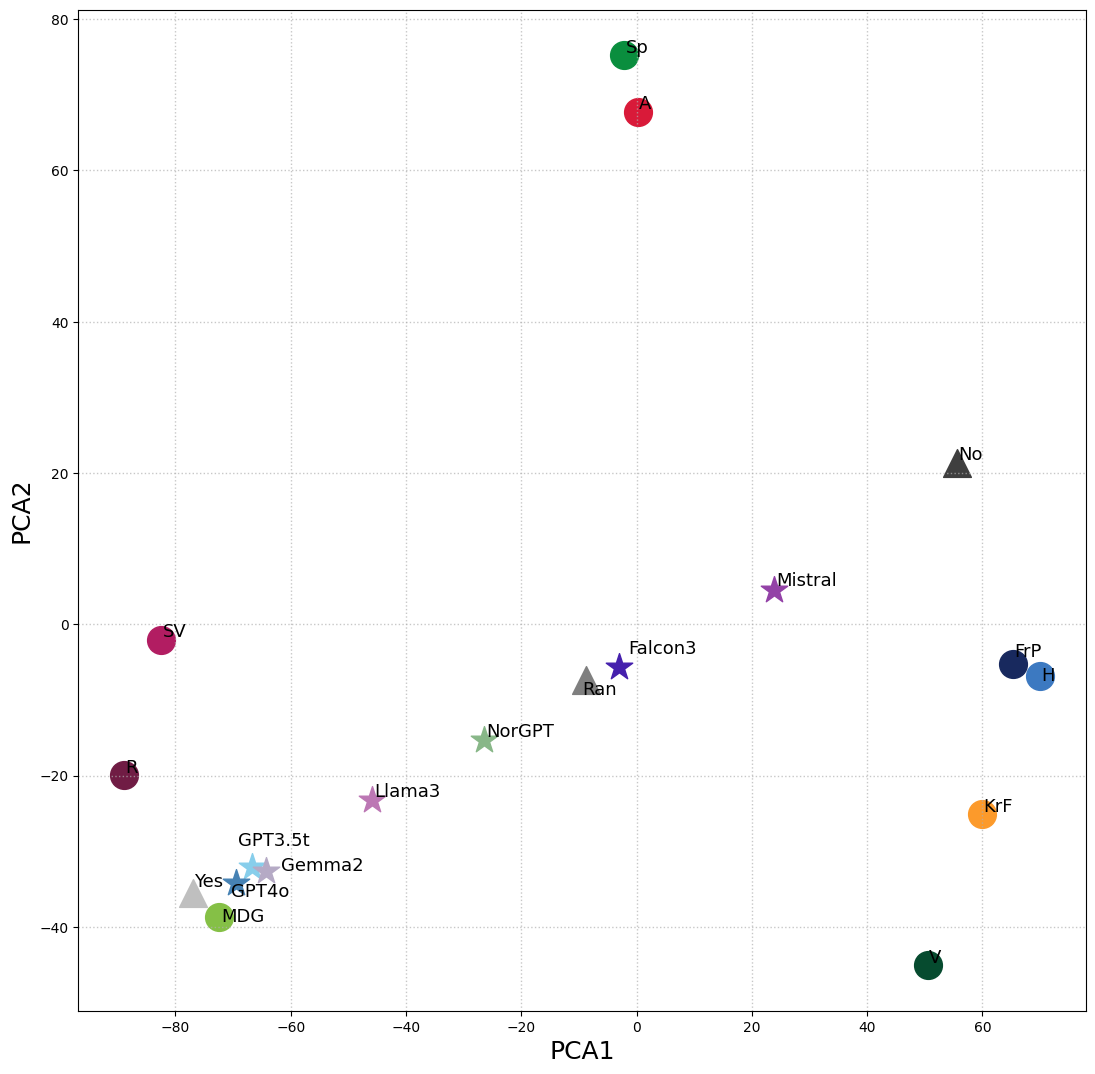

In [25]:
# Reference voters
df_ideology['Yes'] = 1
df_ideology['No'] = -1
df_ideology['Ran'] = np.random.choice([-1, 1], size=len(df_ideology))
men_cols = ['Yes', 'Ran', 'No']

# build the new column via np.where
#df_ideology['Ran'] = np.where(np.random.rand(len(df)) < 0.5, df_ideology['SV'], df_ideology['H'])

colors_men = ['#bfbfbf',
              '#7f7f7f',
              '#3f3f3f',
              ]

# Fit to parties PCA
if fit_pca_parties:
    pca_parties_df, pca_model = utils.do_PCA(df_ideology, [], party_codes)
    pca_models_df, _ = utils.do_PCA(df_ideology, model_names_short_list+men_cols, [], pca_model=pca_model)
    pca_df = pd.concat([pca_parties_df, pca_models_df], ignore_index=False)
    
    utils.make_landscape_plot(pca_df,
                              'political compass parties models',
                              model_names_short_list + men_cols,
                              "NO",
                              party_codes,
                              colors_models[:7]+colors_men,
                              colors_parties,
                              exp_var, signs=[-1,1])
    
    # rotate
    #https://community.plotly.com/t/how-to-rotate-a-plotly-fig/72436/4
    # make lines dir in the plot
    # invert

## Centered

10584
          PCA1       PCA2
R    50.945174 -29.159674
SV   65.691506 -27.910956
MDG  30.256098 -42.830095
A    37.068216  50.015109
Sp   36.412139  63.666283
V   -54.725205 -33.430830
KrF -52.141562 -14.052870
H   -49.511738   2.575313
FrP -63.994628  31.127720
10584
             PCA1      PCA2
GPT3.5t  0.981884 -4.750726
GPT4o    0.006289 -4.876247
Llama3   1.503320 -6.113793
Mistral -2.834120 -3.421140
Gemma2   2.231851 -8.357773
Falcon3 -1.531630 -3.080902
NorGPT   1.981891 -7.086311
Yes     -1.308967 -0.572384
Ran     -2.068240 -1.171240
No      -1.308967 -0.572384
['#701C44', '#B21D62', '#85C046', '#D91A39', '#0A8E3E', '#064B2F', '#FC9A2B', '#3C79C1', '#18295E']
['#87CEEB', '#4682B4', '#BC77B4', '#9342A7', '#B5AAC5', '#4520AD', '#88B788', '#bfbfbf', '#7f7f7f', '#3f3f3f']
Index(['PCA1', 'PCA2'], dtype='object')


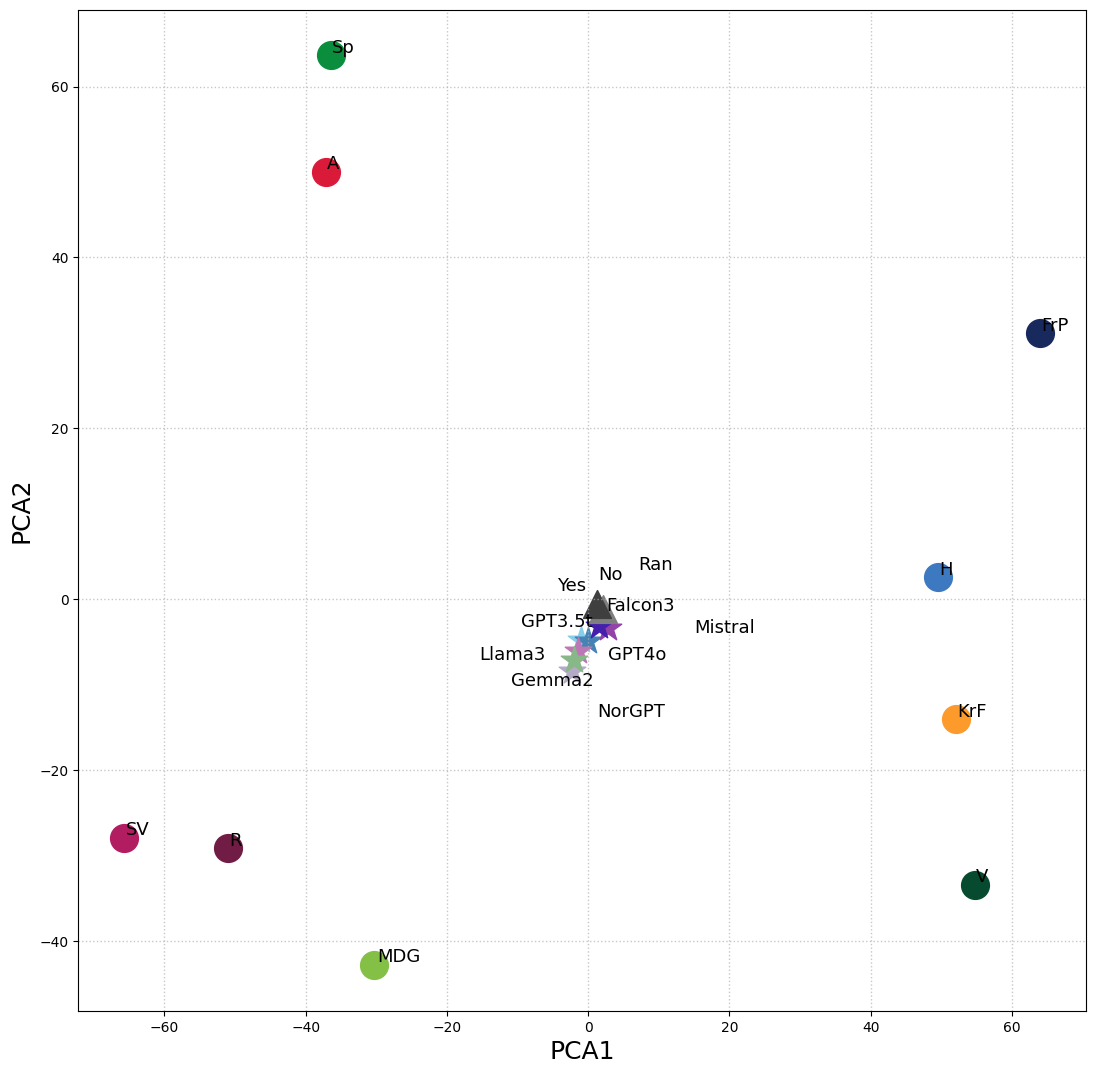

['#701C44', '#B21D62', '#85C046', '#D91A39', '#0A8E3E', '#064B2F', '#FC9A2B', '#3C79C1', '#18295E']
['#87CEEB', '#4682B4', '#BC77B4', '#9342A7', '#B5AAC5', '#4520AD', '#88B788', '#bfbfbf', '#7f7f7f']
Index(['PCA1', 'PCA2'], dtype='object')


In [26]:
df_centered = df_ideology[party_codes+model_names_short_list + men_cols].copy()
df_centered = df_centered.sub(df_centered.mean(axis=0), axis=1)

if True:
    #pca_parties_df, pca_model = utils.plot_landscape2(df_centered, 'political compass parties', [], exp, party_codes, [], colors_parties, exp_var, signs=[-1,1])
    signs = [-1,1]
    zoom_lims = [[-6,6], [-11,1]]
    if undersample:
        signs = [1,1]
        zoom_lims = [[-6,6], [-10,2]]
    # Fit to parties PCA
    if fit_pca_parties:
        pca_parties_df_cent, pca_model_cent = utils.do_PCA(df_centered, [], party_codes)
        pca_models_df_cent, _ = utils.do_PCA(df_centered, model_names_short_list+men_cols, [], pca_model=pca_model_cent)
        pca_df_cent = pd.concat([pca_parties_df_cent, pca_models_df_cent], ignore_index=False)
        
        utils.make_landscape_plot(pca_df_cent,
                                  'political compass parties models cent',
                                  model_names_short_list + men_cols,
                                  "NO",
                                  party_codes,
                                  colors_models[:7]+colors_men,
                                  colors_parties,
                                  exp_var, signs=signs)

        pca_df_cent = pca_df_cent.rename(index={'Yes': 'Yes/No'}).drop(index='No')
        utils.make_landscape_plot(pca_df_cent,
                          'political compass parties models cent zoom',
                          model_names_short_list + men_cols[:2],
                          "NO",
                          party_codes,
                          colors_models[:7]+colors_men[:2],
                          colors_parties,
                          exp_var, signs=signs, xlim=zoom_lims[0], ylim=zoom_lims[1])


## Certainty

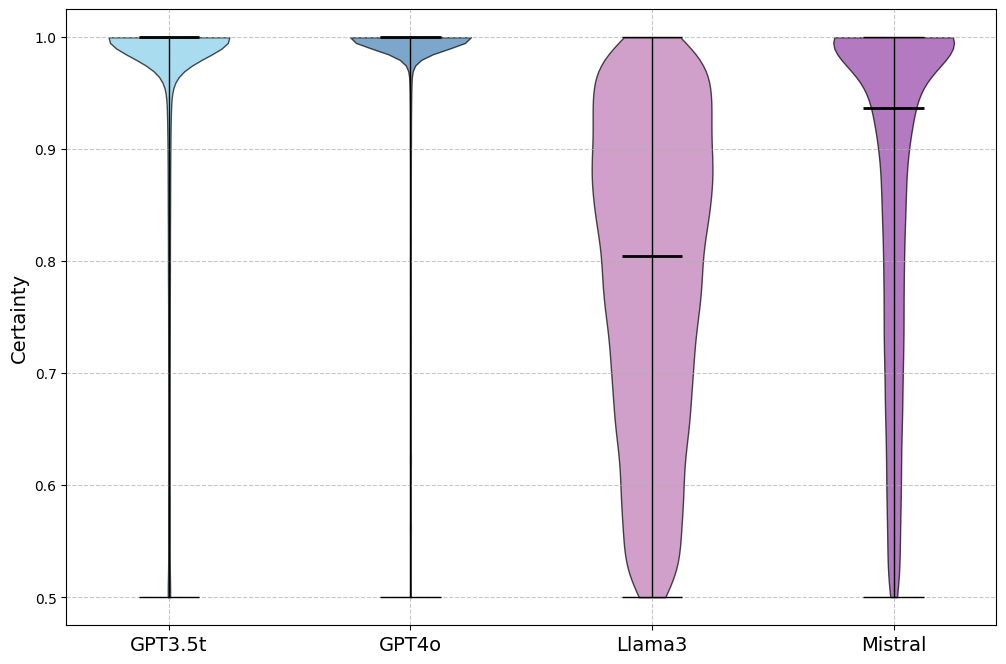

In [27]:
#plot violinplots using the probabilty values
certainty_vals = df_ideology[[f'{m}_p' for m in model_names_short_list]]
cut_off = 4
utils.violinplot(certainty_vals.iloc[:, :cut_off], model_names_short_list[:cut_off], colors_models[:cut_off], exp_var, "violin1")
#['#1E90FF', '#87CEEB', '#000080', '#4682B4'])# Navy, Sky Blue, Dodger Blue, Steel Blue


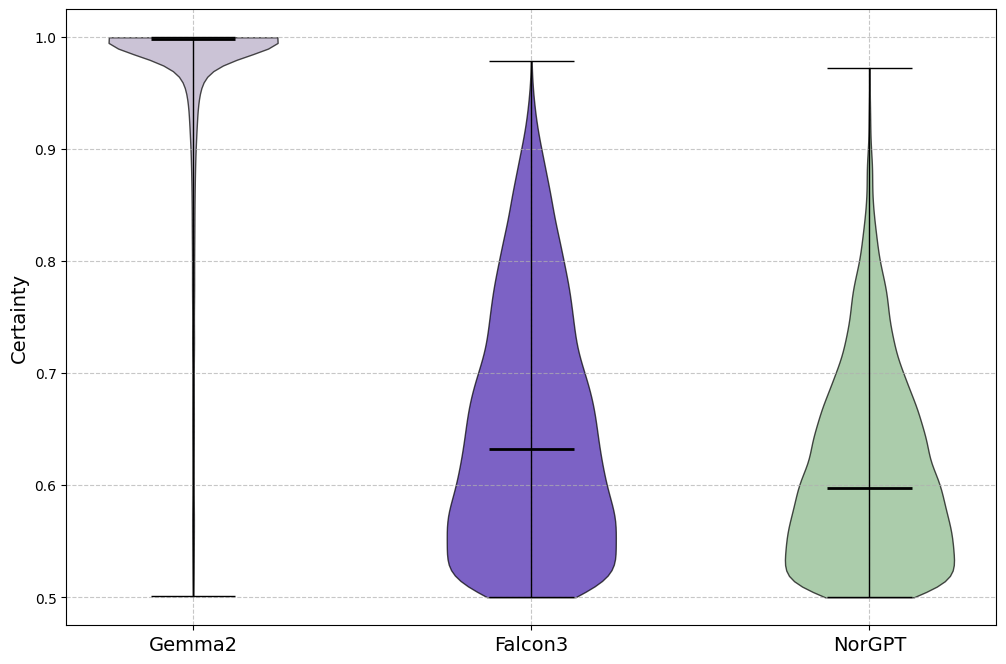

In [28]:
utils.violinplot(certainty_vals.iloc[:, cut_off:], model_names_short_list[cut_off:], colors_models[cut_off:], exp_var, "violin2")

In [29]:
print((certainty_vals.gt(0.95).mean(axis=0)).round(2))
print("Median")
print((certainty_vals.median(axis=0)).round(2))
print((certainty_vals.mean(axis=0)).round(2))
print((certainty_vals.min(axis=0)).round(2))
print((certainty_vals.max(axis=0)).round(2))

GPT3.5t_p    0.85
GPT4o_p      0.94
Llama3_p     0.13
Mistral_p    0.46
Gemma2_p     0.85
Falcon3_p    0.00
NorGPT_p     0.00
dtype: float64
Median
GPT3.5t_p    1.00
GPT4o_p      1.00
Llama3_p     0.80
Mistral_p    0.94
Gemma2_p     1.00
Falcon3_p    0.63
NorGPT_p     0.60
dtype: float64
GPT3.5t_p    0.96
GPT4o_p      0.98
Llama3_p     0.79
Mistral_p    0.87
Gemma2_p     0.97
Falcon3_p    0.65
NorGPT_p     0.61
dtype: float64
GPT3.5t_p    0.5
GPT4o_p      0.5
Llama3_p     0.5
Mistral_p    0.5
Gemma2_p     0.5
Falcon3_p    0.5
NorGPT_p     0.5
dtype: float64
GPT3.5t_p    1.00
GPT4o_p      1.00
Llama3_p     1.00
Mistral_p    1.00
Gemma2_p     1.00
Falcon3_p    0.98
NorGPT_p     0.97
dtype: float64


## Agreement LLMs and Parties

In [30]:
# Initialize a DataFrame to store the agreement results
agreement_df = pd.DataFrame(index=party_codes, columns=model_names_short_list)

# Calculate agreement for each pair
for col in party_codes:
    for model_col in model_names_short_list:
        # Calculate agreement as the percentage of matching values
        agreement = np.round((df_ideology[col] == df_ideology[model_col]).mean() * 100, 1)
        agreement_df.loc[col, model_col] = agreement

#agreement_df
#format agreement scores
agreement_df = agreement_df[model_names_short_list]
agreement_df = agreement_df.transpose()
agreement_df = agreement_df[party_codes]
agreement_df

R    SV   MDG     A    Sp     V   KrF     H   FrP
GPT3.5t  70.9  63.7  69.5  36.3  38.5  36.0  30.9  25.4  32.8
GPT4o    72.0  63.7  69.8  34.8  36.9  34.8  29.4  23.6  31.6
Llama3   63.6  61.1  64.4  44.3  44.6  44.1  41.2  37.0  38.9
Mistral  36.0  42.4  39.0  60.9  57.4  62.0  64.3  67.3  60.3
Gemma2   70.6  63.6  69.4  37.3  38.9  37.8  33.1  27.0  33.3
Falcon3  45.8  48.3  46.7  52.6  51.5  53.2  53.6  54.4  51.5
NorGPT   56.1  57.0  58.1  50.4  48.5  49.8  48.9  46.2  45.3

### Cohen's Kappa

In [31]:
from sklearn.metrics import cohen_kappa_score

# Initialize a DataFrame to store the kappa scores
agreement_df_cohen = pd.DataFrame(index=party_codes, columns=model_names_short_list)

# Calculate Cohen's Kappa for each pair
for party_col in party_codes:
    for model_col in model_names_short_list:
        # Compute kappa score for the two vote columns
        kappa = cohen_kappa_score(df_ideology[party_col], df_ideology[model_col])
        # Optionally round the score for display purposes
        agreement_df_cohen.loc[party_col, model_col] = np.round(kappa, 1)

#agreement_df_cohen

### Balanced Agreement

In [32]:
# Initialize a DataFrame to store the balanced accuracy results
balanced_accuracy_df = pd.DataFrame(index=party_codes, columns=model_names_short_list)

# Calculate balanced accuracy for each pair
for party_col in party_codes:
    for model_col in model_names_short_list:
        # Compute balanced accuracy for the two vote columns
        ba = balanced_accuracy_score(df_ideology[party_col], df_ideology[model_col])
        # Optionally, convert to percentage and round for display
        balanced_accuracy_df.loc[party_col, model_col] = np.round(ba * 100, 1)

### Heat Map - Agreement 

In [33]:
heat_plot(agreement_df, 'Voting agreement between LLMs and Norwegian Political Parties',
          party_codes, model_names_short_list, f"heatmap_agreement_{exp_var}")

In [34]:
write_latex_variable("minllmpartyag", f"{agreement_df.min().min():.1f}")
write_latex_variable("maxllmpartyag", f"{agreement_df.max().max():.1f}")
write_latex_variable("meanllmpartyag", f"{agreement_df.mean().mean():.1f}")

write to latex
\newcommand{\minllmpartyag}{23.6}\ignorespaces

write to latex
\newcommand{\maxllmpartyag}{72.0}\ignorespaces

write to latex
\newcommand{\meanllmpartyag}{48.5}\ignorespaces



### Heat Map - Balanced Agreement 

In [35]:
balanced_accuracy_df['Mean'] = balanced_accuracy_df.mean(axis=1).round(1)
balanced_accuracy_df.loc['Mean'] = balanced_accuracy_df.mean(axis=0).round(1)
print(balanced_accuracy_df)

heat_plot(balanced_accuracy_df.T,
               'Balanced Voting agreement between LLMs and Norwegian Political Parties', party_codes+['Mean'], model_names_short_list+['Mean'],
               f"heatmap_bal_agreement_{exp_var}", zmin=30, zmax=40)
write_latex_variable("minllmpartybalag", f"{balanced_accuracy_df.min().min():.2f}")
write_latex_variable("maxllmpartybalag", f"{balanced_accuracy_df.max().max():.2f}")
write_latex_variable("meanllmpartybalag", f"{balanced_accuracy_df.mean().mean():.2f}")


     GPT3.5t GPT4o Llama3 Mistral Gemma2 Falcon3 NorGPT  Mean
R       35.2  35.0   35.8    33.8   36.4    33.4   35.9  35.1
SV      35.1  34.6   36.5    33.8   35.7    33.5   36.7  35.1
MDG     37.3  36.5   39.0    36.7   38.5    35.3   39.4  37.5
A       35.0  34.6   36.5    35.1   34.8    33.9   36.8  35.2
Sp      34.4  33.8   35.3    33.7   34.0    33.3   34.6  34.2
V       35.4  35.2   36.7    35.6   35.7    34.3   36.5  35.6
KrF     35.3  35.1   37.3    35.8   35.8    34.5   37.3  35.9
H       35.1  35.0   36.8    35.6   34.7    34.5   36.3  35.4
FrP     32.8  32.7   32.6    34.2   32.2    32.9   32.9  32.9
Mean    35.1  34.7   36.3    34.9   35.3    34.0   36.3  35.2


write to latex
\newcommand{\minllmpartybalag}{32.20}\ignorespaces

write to latex
\newcommand{\maxllmpartybalag}{39.40}\ignorespaces

write to latex
\newcommand{\meanllmpartybalag}{35.22}\ignorespaces



## EBI

In [36]:

df_ebis = pd.DataFrame()

for model_name in model_names:
    model_name_short = model_names_short[model_name] 
    df1 = df_ideology[['id',model_name_short]].copy()
    df2 = dfs_entity[model_name][[f'{model_name}_{p}_vote' for p in party_codes]]
    #df_ebi = pd.merge(df1, df2, on="id")
    df_ebi = df1.join(df2, how="inner")
    df_ebi.replace(-1, 0, inplace=True)
    
    sum_diff_per_party = (
        df_ebi
          .filter(regex=rf"^{model_name}_.*_vote$")
          .sub(df_ebi[model_name_short], axis=0)
          .sum()
          .div(len(df_ebi))
          .mul(100)
          .round(1)
    )
    
    
    
    df_one_row = pd.DataFrame([sum_diff_per_party])
    df_one_row.columns = (
        df_one_row
          .columns
          .str.replace(rf"^{model_name}_", "", regex=True)
          .str.replace(r"_vote$", "", regex=True)
    )
    df_one_row.insert(0, "model", model_name_short)
    
    # append this one‑row frame
    df_ebis = pd.concat([df_ebis, df_one_row], 
                       ignore_index=True)


df_ebis.set_index("model", inplace=True)

# Compute row means
df_ebis['Mean'] = (df_ebis.mean(axis=1)).round(1)
df_ebis.loc['Mean'] = (df_ebis.mean(axis=0)).round(1)

print(df_ebis)
heat_plot(df_ebis, "Entity Bias", party_codes+['Mean'], model_names_short_list+['Mean'], f"entity_bias_{exp_var}" , zmin=-100, zmax=100, zmid=0, colorscale='RdBu')


            R    SV   MDG     A    Sp     V   KrF     H   FrP  Mean
model                                                              
GPT3.5t  -3.4  -2.2  -6.2  -3.1  -1.9   0.9  -2.5  -1.1 -13.4  -3.7
GPT4o    -0.1   0.7  -0.6   0.6   0.8  -0.7  -0.2  -1.8  -3.3  -0.5
Llama3   -9.1  -6.1  -7.7 -15.8 -13.5  -5.2 -20.3 -28.8 -40.5 -16.3
Mistral -23.1 -23.6 -19.2 -21.8 -22.4 -19.9 -21.2 -19.3 -23.3 -21.5
Gemma2   -7.6  -8.7  -4.4  -6.3 -10.0 -14.7 -11.9 -15.1 -22.3 -11.2
Falcon3 -37.1  -1.4 -17.1  16.8  -1.7 -23.6  14.6 -35.0  -9.0 -10.4
NorGPT  -31.8  26.7   7.4   5.3   5.5 -16.5  13.0 -47.3  -5.0  -4.7
Mean    -16.0  -2.1  -6.8  -3.5  -6.2 -11.4  -4.1 -21.2 -16.7  -9.8


## Absolute EBI

In [37]:

for model_name in model_names:
    vote_columns[model_name] = [f'{model_name}_{party}_vote' for party in party_codes]

disagreements_pos = {}
disagreements_neg = {}

for model_name in model_names:
    df_ideology_for = df_ideology.loc[df_ideology[f'{model_names_short[model_name]}'] == 1].copy()
    df_ideology_against = df_ideology.loc[df_ideology[f'{model_names_short[model_name]}'] == -1].copy()

    #df_ideology_for.sort_values('id', inplace=True)
    df_ideology_for.sort_index(inplace=True)
    #df_ideology_against.sort_values('id', inplace=True)
    df_ideology_against.sort_index(inplace=True)
    
    #df_ideology_for.set_index('id', inplace=True, drop=False)
    #df_ideology_against.set_index('id', inplace=True, drop=False)
    
    df_entity_for = dfs_entity[model_name].loc[dfs_entity[model_name]['id'].isin(df_ideology_for['id'])].copy()
    df_entity_against = dfs_entity[model_name].loc[dfs_entity[model_name]['id'].isin(df_ideology_against['id'])].copy()

    #df_entity_for.sort_values('id', inplace=True)
    #df_entity_against.sort_values('id', inplace=True)
    df_entity_for.set_index('id', inplace=True, drop=False)
    df_entity_against.set_index('id', inplace=True, drop=False)
    df_entity_for.sort_index(inplace=True)
    df_entity_against.sort_index(inplace=True)

    assert df_entity_for.index.equals(df_ideology_for.index), \
       "Mismatch in the set or order of motion IDs!"

    
    agreements = []
    disagreements_pos[model_names_short[model_name]] = []
    disagreements_neg[model_names_short[model_name]] = []
    
    #party_names = ['PvdD', 'GroenLinks-PvdA', 'Volt', 'SP', 'DENK',  'D66', 'ChristenUnie', 'NSC', 'CDA','BBB', 'VVD', 'SGP', 'PVV', 'FVD', 'JA21']
    # Calculate agreement and disagreement percentages
    for col in vote_columns[model_name]:
        model_col = f'{model_names_short[model_name]}'
        #df_ideology_for[model_col]     = df_ideology_for[model_col].astype(int)
        #df_entity_for[col]            = df_entity_for[col].astype(int)
        #df_ideology_against[model_col] = df_ideology_against[model_col].astype(int)
        #df_entity_against[col]           = df_entity_against[col].astype(int)
        
        disagreement_neg1 = (df_ideology_for[model_col] == -df_entity_for[col]).mean() *100
        #disagreement_pos1 = ((df_ideology_against[model_col] != df_entity_against[col]) & (df_ideology_against[f'{model_names_short[model_name]}'] != -df_entity_against[col])).mean() *100
        disagreement_pos1 = (df_ideology_against[model_col] == -df_entity_against[col]).mean() *100
        
        disagreements_pos[model_names_short[model_name]].append(disagreement_pos1)
        disagreements_neg[model_names_short[model_name]].append(disagreement_neg1)


## Heatmap - Absolute Entity Bias

In [38]:
l_pos = []
l_neg = []

for model_name in model_names:
    l_pos.append(np.round(disagreements_pos[model_names_short[model_name]], 1))
    l_neg.append(np.round(disagreements_neg[model_names_short[model_name]], 1)) 


positive_data = np.array(l_pos)
negative_data = np.array(l_neg)

#positive_data[np.isnan(positive_data)] = 0
#positive_data[np.isnan(negative_data)] = 0


# Add mean
row_means = np.round(positive_data.mean(axis=1), 1)    # shape (7,)
col_means = np.round(positive_data.mean(axis=0), 1)    # shape (9,)
positive_data = np.hstack([positive_data, row_means[:,None]])
bottom_row = np.append(col_means, np.round(row_means.mean(), 1))
positive_data = np.vstack([positive_data, bottom_row[None,:]])

row_means = np.round(negative_data.mean(axis=1), 1)    # shape (7,)
col_means = np.round(negative_data.mean(axis=0), 1)    # shape (9,)
negative_data = np.hstack([negative_data, row_means[:,None]])
bottom_row = np.append(col_means, np.round(row_means.mean(), 1))
negative_data = np.vstack([negative_data, bottom_row[None,:]])

utils.plot_heatmap('pos_neg_bias', positive_data, negative_data, party_codes+['Mean'], model_names_short_list+['Mean'], exp_var)
#print(positive_data)
#print(negative_data)

## Categorical Analysis

In [39]:
category_col = 'category'
#del_cat = ['Presidency of the Storting', 'Control and Constitution', 'Other']
#df_cat = df_cat[~df_cat[category_col].isin(del_cat)]

df_cat_count = pd.DataFrame(df_cat[category_col].value_counts()/len(df_cat)*100)
df_cat_count['category'] = df_cat_count['category'].map("{:.1f}".format)
df_cat_count

#f"{proportions[1.0]*100:.2f}"

category
Finance                              14.7
Energy and environmental             13.7
Health and care                      13.6
Municipal and administrative         10.3
Business                             10.2
Transportation and communication      8.4
Labor and social                      7.0
Justice                               6.6
Education and research                5.7
Family and culture                    5.2
Foreign Affairs and Defence           4.5

In [40]:
heat_plot(df_cat_count,
               'Political Categories', ['category'], list(df_cat_count.index),
               f"pol_cat_{exp_var}")

## One hot encoding

In [41]:
# make category into a list of strings
df_cat[category_col] = df_cat[category_col].apply(lambda x: "['" + x + "']")
df_cat[f'{category_col}'] = df_cat[f'{category_col}'].apply(ast.literal_eval)

# Initialize MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Fit and transform the column with lists
one_hot_encoded = mlb.fit_transform(df_cat[f'{category_col}'])

# Create a DataFrame with the one-hot encoded columns
one_hot_df = pd.DataFrame(one_hot_encoded, columns=mlb.classes_, index=df_cat.index)

# Concatenate the one-hot encoded columns with the original DataFrame
df = pd.concat([df_cat, one_hot_df], axis=1)
df.set_index('id', inplace=True, drop=False)

#print(df_ideology.columns)

df_cat2 = df_ideology.merge(df, left_index=True, right_index=True, how='left', suffixes=('', '_drop'))

df_cat2.set_index('id', inplace=True, drop=False)
#print(df_cat2.columns)
#print(df_cat2)

## PCA

Category: Labor and social
743
0
743
          PCA1       PCA2
R    24.770260 -12.081909
SV   22.655473  -1.397449
MDG  16.394451  -8.080652
A     7.105452  16.422635
Sp    5.928479  17.994209
V   -20.204370  -3.876085
KrF -18.762249  -1.735208
H   -20.224131  -0.464812
FrP -17.663367  -6.780729
743
              PCA1       PCA2
GPT3.5t  19.285575 -14.566539
GPT4o    18.725692 -15.113998
Llama3   10.971354  -9.365534
Mistral  -8.157169   2.533629
Gemma2   17.260054 -13.933136
Falcon3   0.637936  -4.678512
NorGPT    6.861437  -6.576903
['#701C44', '#B21D62', '#85C046', '#D91A39', '#0A8E3E', '#064B2F', '#FC9A2B', '#3C79C1', '#18295E']
['#87CEEB', '#4682B4', '#BC77B4', '#9342A7', '#B5AAC5', '#4520AD', '#88B788', '#407240']
Index(['PCA1', 'PCA2'], dtype='object')


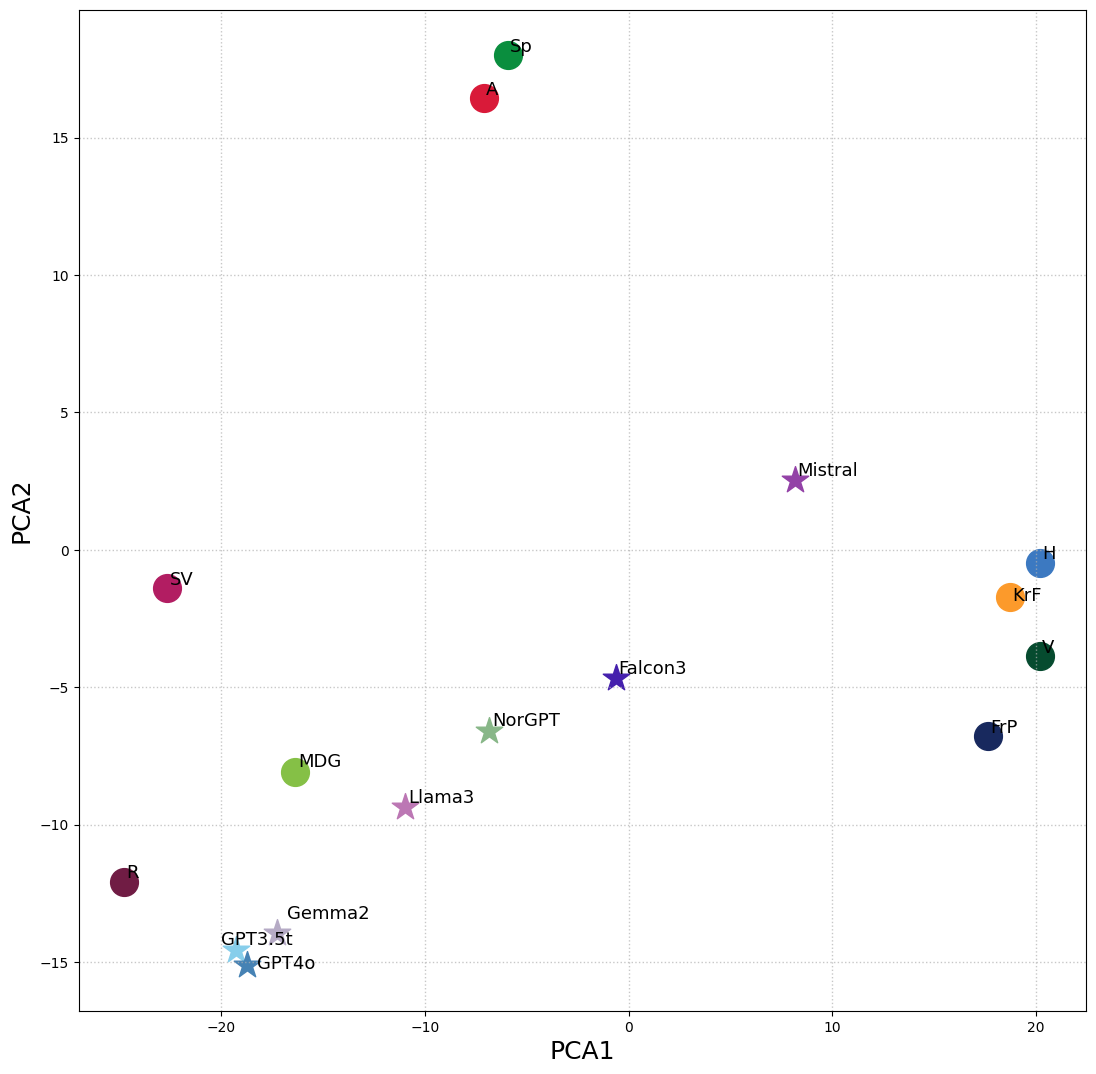

Category: Health and care
1436
1
1436
          PCA1       PCA2
R    29.986228 -10.464163
SV   29.679805  -1.446202
MDG  21.324889 -22.726295
A     9.268767  24.741690
Sp   11.235660  25.114336
V   -25.201617  -8.534370
KrF -25.277700   1.235501
H   -27.923548   7.641148
FrP -23.092483 -15.561644
1436
              PCA1       PCA2
GPT3.5t  18.412625 -24.057135
GPT4o    18.962297 -24.635044
Llama3   14.318431 -18.976328
Mistral  -7.648871  -0.069214
Gemma2   18.031099 -23.161327
Falcon3   0.962948  -2.726346
NorGPT    9.527232 -13.244740
['#701C44', '#B21D62', '#85C046', '#D91A39', '#0A8E3E', '#064B2F', '#FC9A2B', '#3C79C1', '#18295E']
['#87CEEB', '#4682B4', '#BC77B4', '#9342A7', '#B5AAC5', '#4520AD', '#88B788', '#407240']
Index(['PCA1', 'PCA2'], dtype='object')


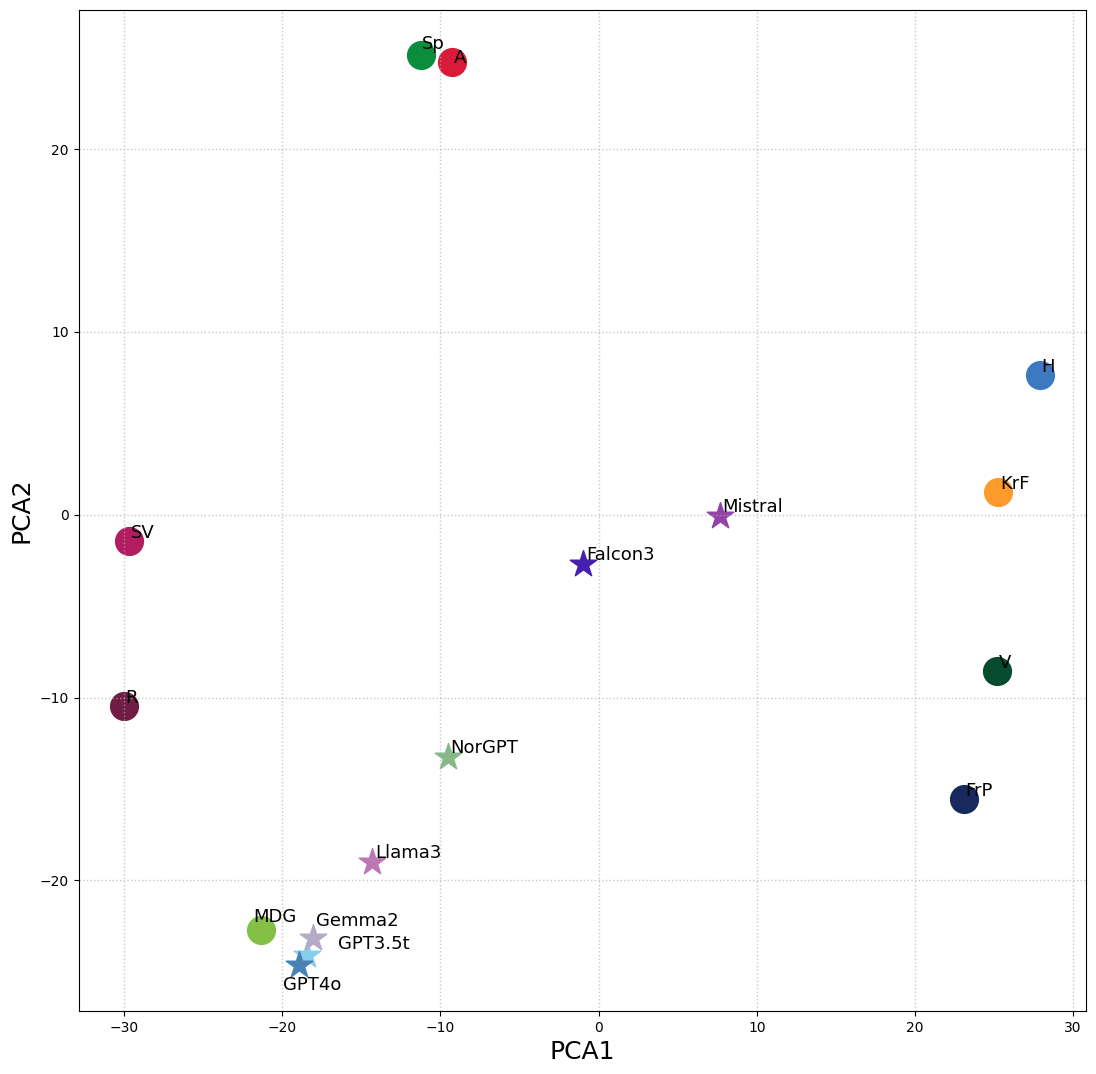

Category: Municipal and administrative
1095
2
1095
          PCA1       PCA2
R    31.931589  -2.589192
SV   28.005146   3.442938
MDG  25.838379  -5.798046
A   -10.134015  21.040714
Sp   -7.433612  23.853350
V   -10.025272 -18.130420
KrF -13.124668 -15.637956
H   -22.718681  -4.007221
FrP -22.338867  -2.174167
1095
              PCA1      PCA2
GPT3.5t  24.270663 -7.344321
GPT4o    25.365179 -7.320208
Llama3   14.288425 -4.897399
Mistral  -8.388635  2.572745
Gemma2   22.869252 -7.745677
Falcon3  -0.094988  1.174132
NorGPT    7.853488 -3.757299
['#701C44', '#B21D62', '#85C046', '#D91A39', '#0A8E3E', '#064B2F', '#FC9A2B', '#3C79C1', '#18295E']
['#87CEEB', '#4682B4', '#BC77B4', '#9342A7', '#B5AAC5', '#4520AD', '#88B788', '#407240']
Index(['PCA1', 'PCA2'], dtype='object')


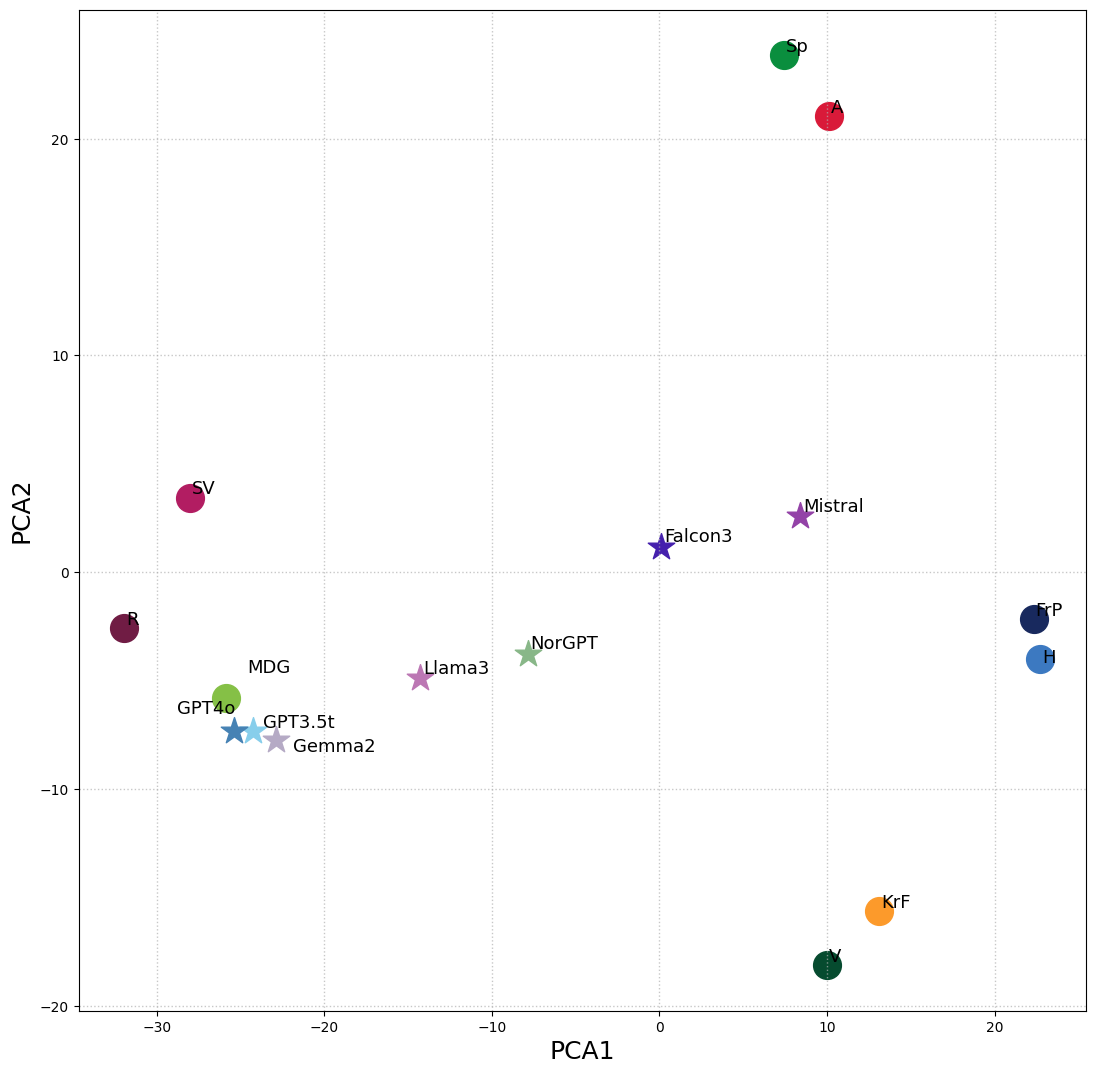

Category: Finance
1561
3
1561
          PCA1       PCA2
R    34.946396  -9.775684
SV   29.667043   0.506292
MDG  27.043375 -17.672814
A     5.611332  21.354029
Sp    6.221056  26.077308
V   -24.183407  -7.760691
KrF -25.733933  -5.314450
H   -27.038158  -2.620871
FrP -26.533705  -4.793117
1561
              PCA1       PCA2
GPT3.5t  28.714347  -9.324600
GPT4o    29.854865 -10.171419
Llama3   17.642203  -4.504820
Mistral -13.446157  -2.131833
Gemma2   25.385642  -9.876175
Falcon3  -0.461518  -5.961443
NorGPT    8.398673  -5.174392
['#701C44', '#B21D62', '#85C046', '#D91A39', '#0A8E3E', '#064B2F', '#FC9A2B', '#3C79C1', '#18295E']
['#87CEEB', '#4682B4', '#BC77B4', '#9342A7', '#B5AAC5', '#4520AD', '#88B788', '#407240']
Index(['PCA1', 'PCA2'], dtype='object')


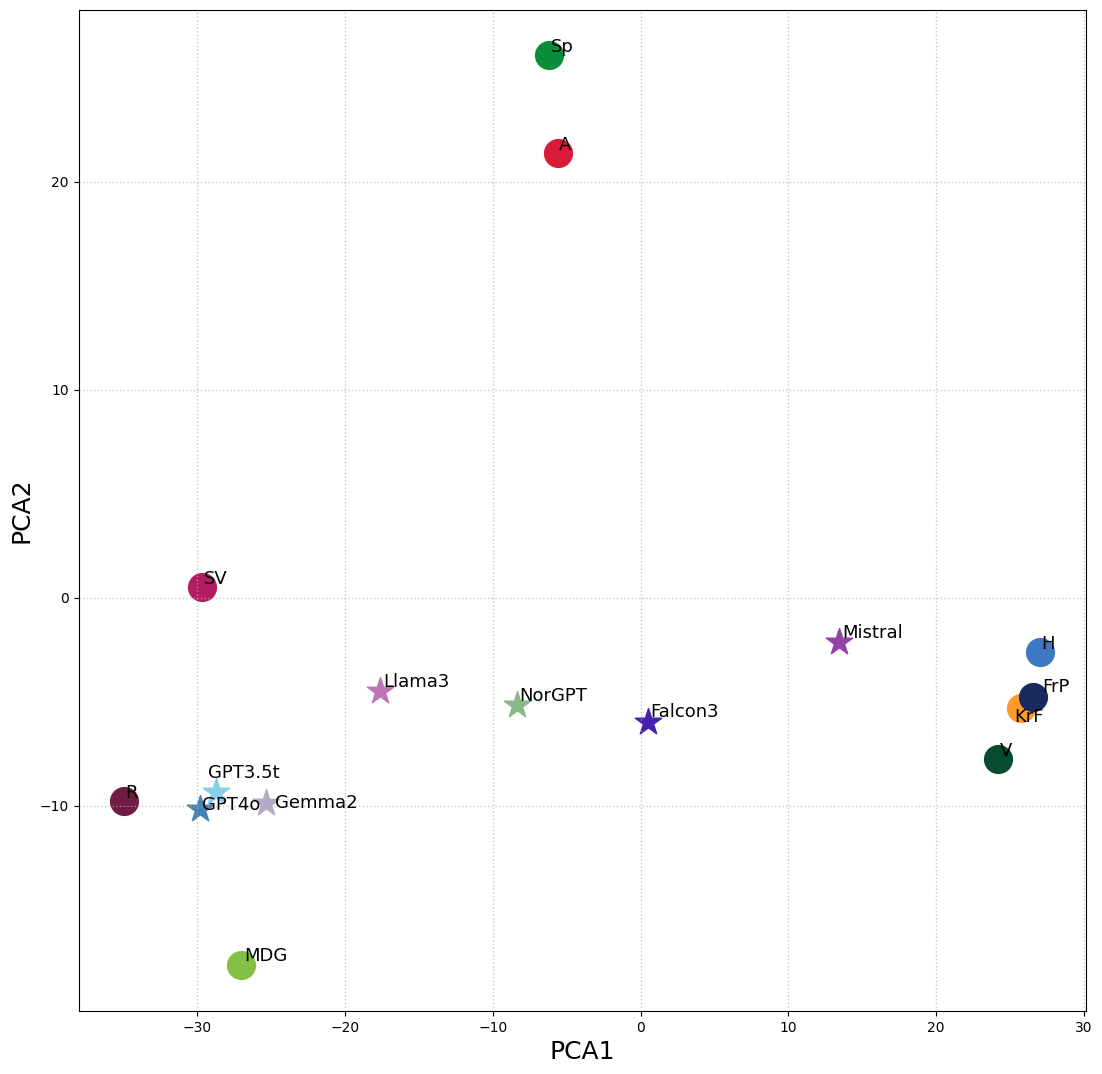

Category: Energy and environmental
1447
4
1447
          PCA1       PCA2
R    33.376217  -5.141438
SV   29.239776  -7.364192
MDG  30.865966   6.221197
A   -15.252682 -18.121282
Sp  -15.825753 -22.771592
V    -3.014668  23.847920
KrF -14.014130  17.274042
H   -21.818015   8.482413
FrP -23.556710  -2.427068
1447
              PCA1      PCA2
GPT3.5t  27.345225  0.614223
GPT4o    28.843823  0.833371
Llama3   21.710195 -0.016490
Mistral  -6.645979 -2.062741
Gemma2   28.407585  1.244476
Falcon3   3.606941 -2.672241
NorGPT   13.939469 -0.729617
['#701C44', '#B21D62', '#85C046', '#D91A39', '#0A8E3E', '#064B2F', '#FC9A2B', '#3C79C1', '#18295E']
['#87CEEB', '#4682B4', '#BC77B4', '#9342A7', '#B5AAC5', '#4520AD', '#88B788', '#407240']
Index(['PCA1', 'PCA2'], dtype='object')


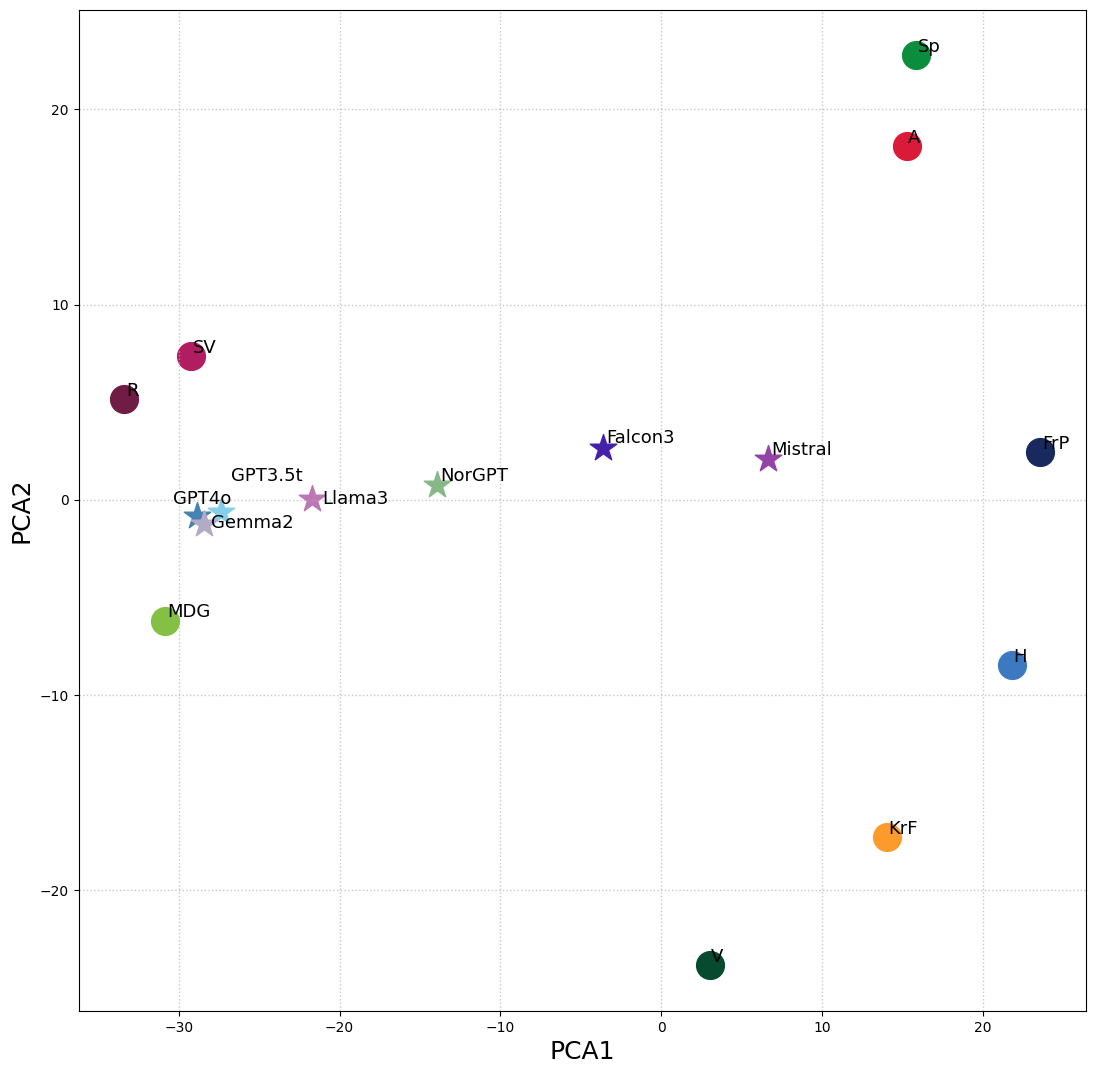

Category: Family and culture
552
5
552
          PCA1       PCA2
R    17.417159  -6.694306
SV   19.075039  -0.959735
MDG  14.475488 -11.986593
A     5.648398  11.439447
Sp    7.213068  16.146718
V   -15.721272  -3.610470
KrF -14.837266  -0.968718
H   -16.417768  -1.227744
FrP -16.852846  -2.138599
552
              PCA1      PCA2
GPT3.5t  12.913134 -8.506001
GPT4o    13.510799 -9.600806
Llama3    9.326217 -5.660735
Mistral  -3.643067  3.523736
Gemma2   13.143979 -8.454316
Falcon3  -0.373669  0.557468
NorGPT    7.948986 -3.679278
['#701C44', '#B21D62', '#85C046', '#D91A39', '#0A8E3E', '#064B2F', '#FC9A2B', '#3C79C1', '#18295E']
['#87CEEB', '#4682B4', '#BC77B4', '#9342A7', '#B5AAC5', '#4520AD', '#88B788', '#407240']
Index(['PCA1', 'PCA2'], dtype='object')


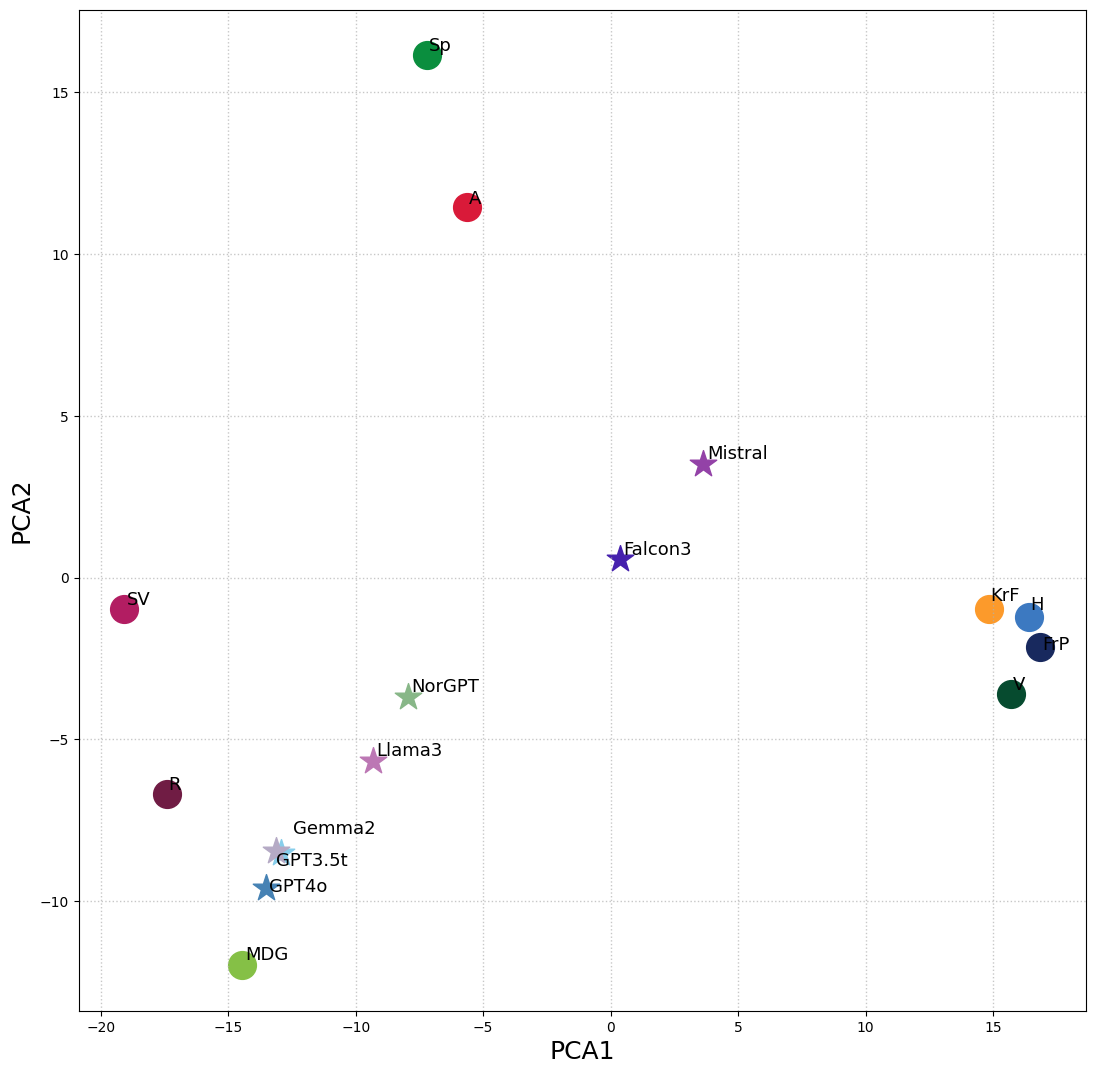

Category: Foreign Affairs and Defence
478
6
478
          PCA1       PCA2
R    21.434760  -4.106223
SV   19.781976  -1.626419
MDG  19.213148   7.242122
A    -8.849805  -8.115767
Sp   -5.421100 -13.961201
V    -6.559278  15.009587
KrF -11.323007   3.919647
H   -14.447068   1.573619
FrP -13.829626   0.064635
478
              PCA1      PCA2
GPT3.5t  16.431693  2.673199
GPT4o    18.750683  3.012648
Llama3   11.395644  0.950879
Mistral  -8.096242 -0.984463
Gemma2   18.301484  2.258660
Falcon3  -1.859633  0.661129
NorGPT    5.486653  0.006105
['#701C44', '#B21D62', '#85C046', '#D91A39', '#0A8E3E', '#064B2F', '#FC9A2B', '#3C79C1', '#18295E']
['#87CEEB', '#4682B4', '#BC77B4', '#9342A7', '#B5AAC5', '#4520AD', '#88B788', '#407240']
Index(['PCA1', 'PCA2'], dtype='object')


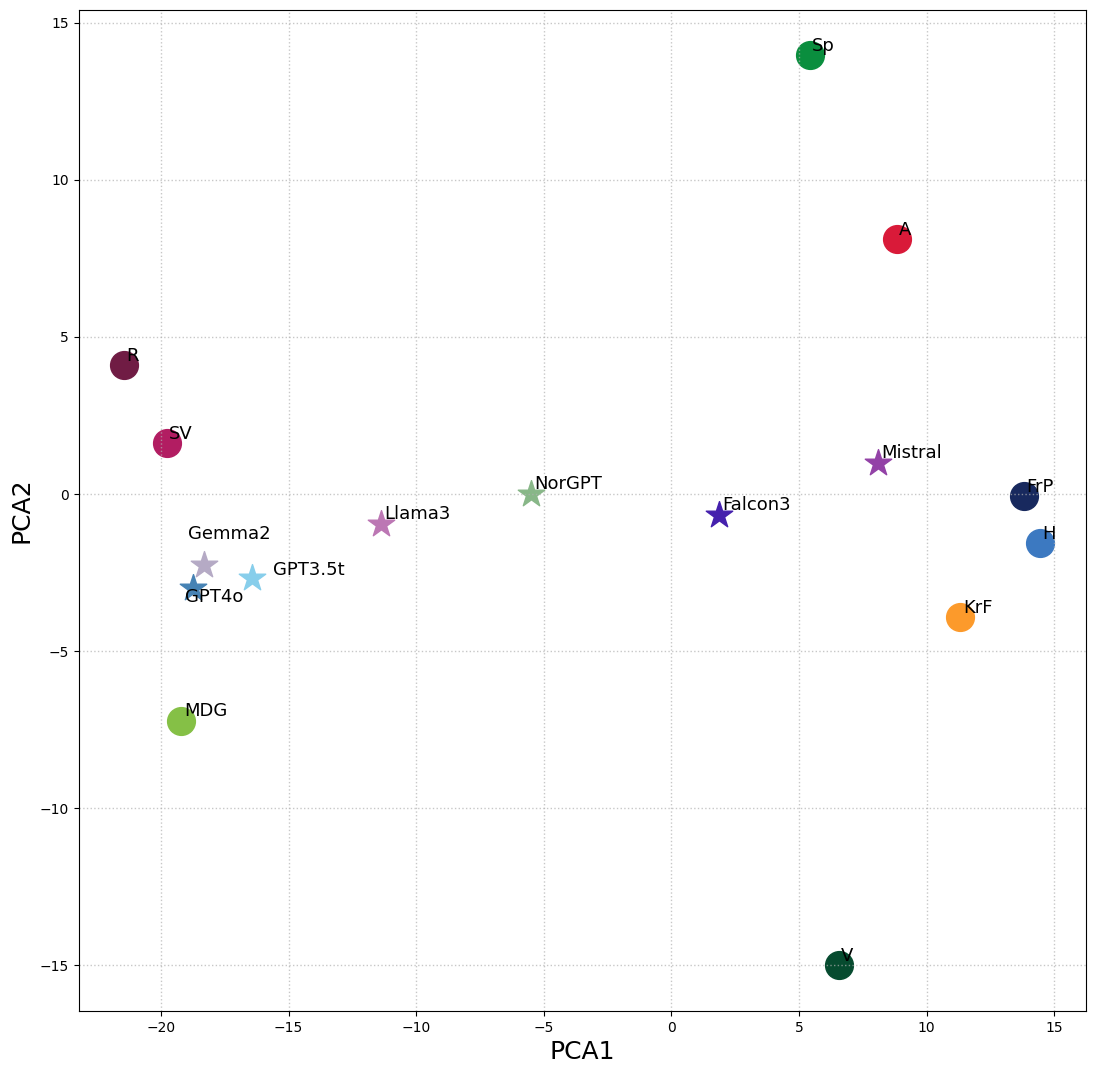

Category: Business
1083
7
1083
          PCA1       PCA2
R    27.761022  -6.653038
SV   25.955260  -0.550135
MDG  23.507398 -15.607191
A     1.886198  22.872777
Sp    2.615101  24.284831
V   -17.535238 -15.520033
KrF -20.441822  -5.048161
H   -22.141979  -4.137029
FrP -21.605939   0.357980
1083
              PCA1       PCA2
GPT3.5t  17.989278 -13.926342
GPT4o    19.047687 -14.204518
Llama3   12.521834 -11.204595
Mistral  -7.472767   0.878860
Gemma2   16.746043 -12.761984
Falcon3   2.221802  -5.540692
NorGPT    6.455610  -7.171520
['#701C44', '#B21D62', '#85C046', '#D91A39', '#0A8E3E', '#064B2F', '#FC9A2B', '#3C79C1', '#18295E']
['#87CEEB', '#4682B4', '#BC77B4', '#9342A7', '#B5AAC5', '#4520AD', '#88B788', '#407240']
Index(['PCA1', 'PCA2'], dtype='object')


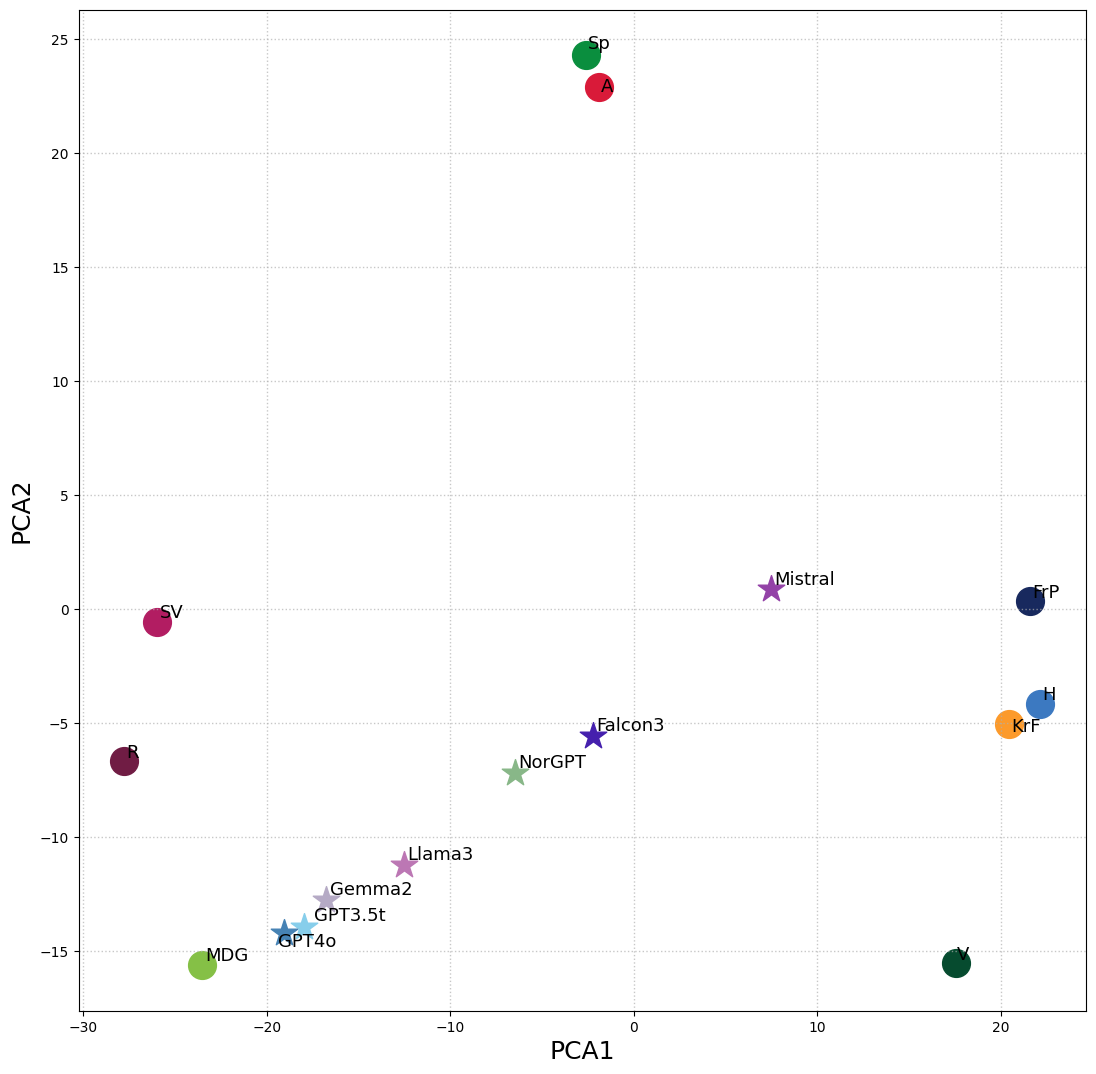

Category: Education and research
604
8
604
          PCA1       PCA2
R    21.282252  -4.998178
SV   22.118853  -4.003975
MDG  15.781745  -9.889698
A     3.981425  16.451331
Sp    3.213742  16.717689
V   -16.269338  -7.516843
KrF -16.221897  -8.015326
H   -17.459015  -0.082791
FrP -16.427767   1.337791
604
              PCA1       PCA2
GPT3.5t  15.392502 -10.631935
GPT4o    15.524222 -11.454732
Llama3   12.047373  -8.661729
Mistral  -1.525778   1.457124
Gemma2   14.794448 -10.453153
Falcon3   1.978768  -2.118698
NorGPT    7.867945  -5.058479
['#701C44', '#B21D62', '#85C046', '#D91A39', '#0A8E3E', '#064B2F', '#FC9A2B', '#3C79C1', '#18295E']
['#87CEEB', '#4682B4', '#BC77B4', '#9342A7', '#B5AAC5', '#4520AD', '#88B788', '#407240']
Index(['PCA1', 'PCA2'], dtype='object')


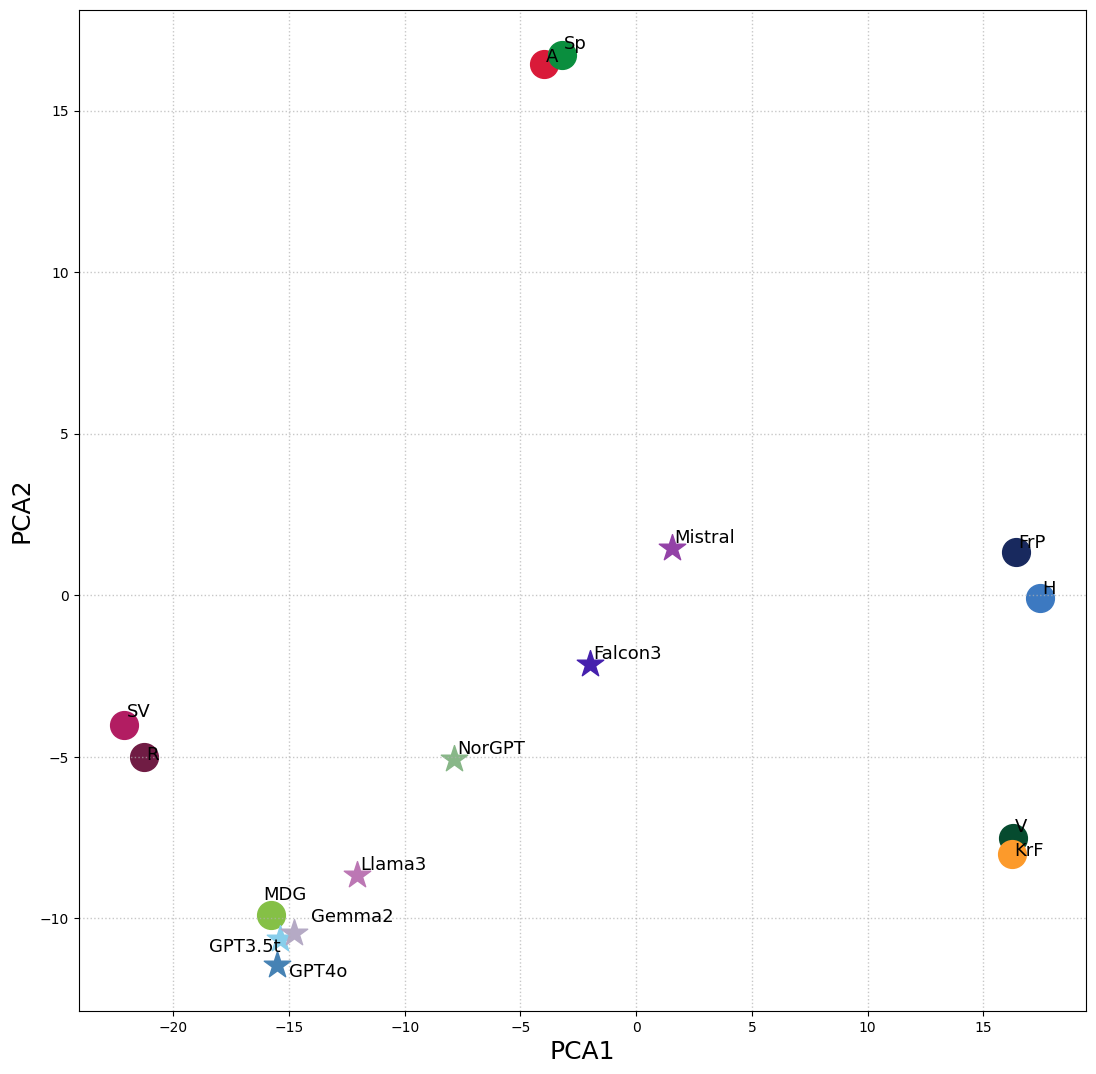

Category: Transportation and communication
885
9
885
          PCA1       PCA2
R    22.964994  -3.465803
SV   21.703660  -2.551543
MDG  21.751479  -9.231700
A    -1.712485  18.582094
Sp   -0.262571  23.254039
V   -11.642253 -13.547649
KrF -16.011579  -9.252320
H   -18.060201  -4.629344
FrP -18.731043   0.842227
885
              PCA1      PCA2
GPT3.5t  17.424401 -4.927001
GPT4o    18.954360 -5.200132
Llama3   11.859065 -4.859045
Mistral  -5.495029  2.257332
Gemma2   18.174240 -5.365048
Falcon3   1.247221  1.529638
NorGPT    4.129648 -2.174024
['#701C44', '#B21D62', '#85C046', '#D91A39', '#0A8E3E', '#064B2F', '#FC9A2B', '#3C79C1', '#18295E']
['#87CEEB', '#4682B4', '#BC77B4', '#9342A7', '#B5AAC5', '#4520AD', '#88B788', '#407240']
Index(['PCA1', 'PCA2'], dtype='object')


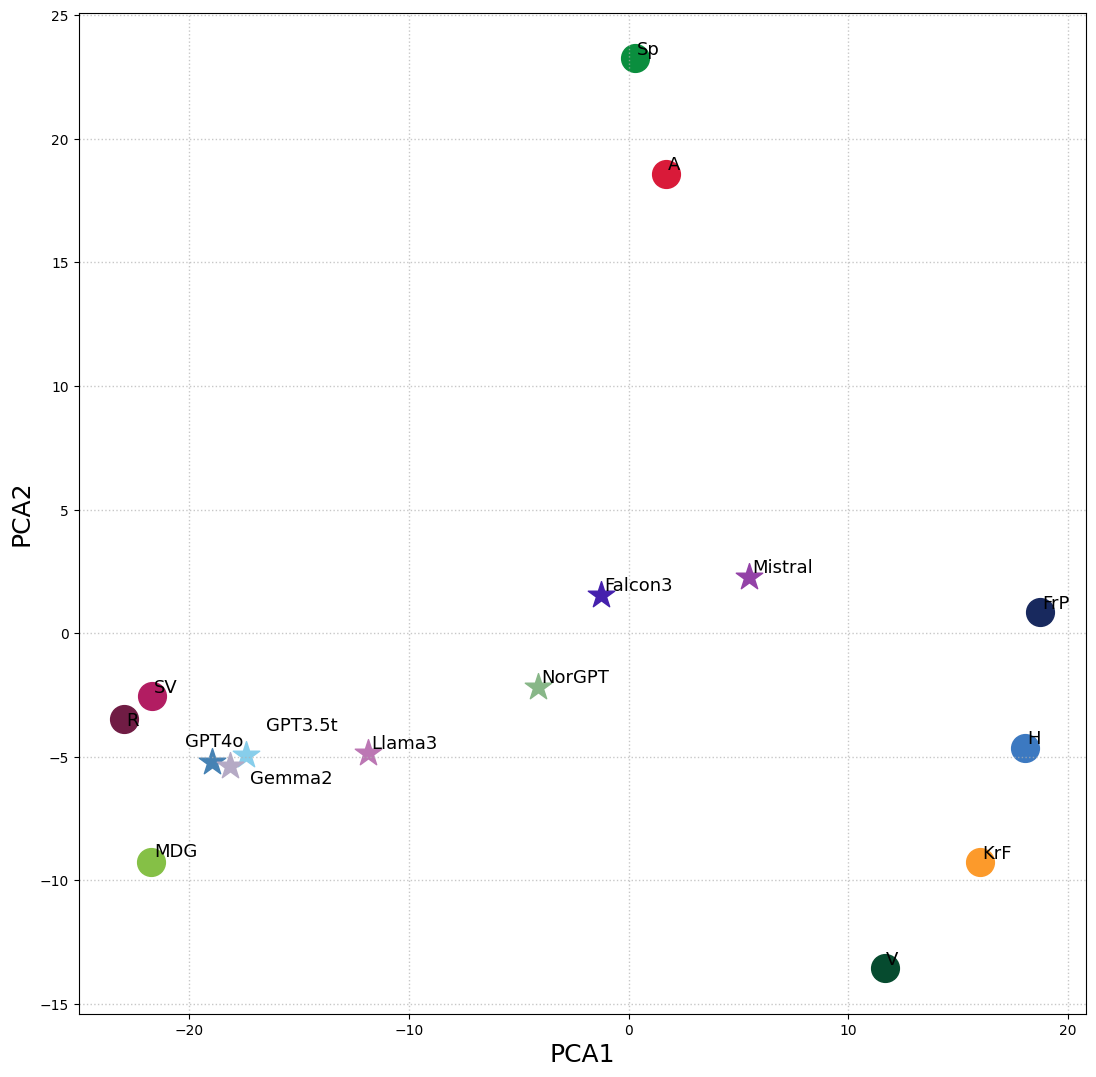

Category: Justice
700
10
700
          PCA1       PCA2
R    20.574909  -2.763557
SV   20.465231   2.397313
MDG  19.779681  -2.453619
A    -4.276426  18.060540
Sp   -8.291843  17.276320
V    -3.008343 -15.909464
KrF -11.848480 -10.834710
H   -17.623460  -5.148786
FrP -15.771268  -0.624038
700
              PCA1      PCA2
GPT3.5t  16.108168 -1.347715
GPT4o    16.145625 -1.560361
Llama3   11.193353 -0.855556
Mistral  -7.895393 -0.017548
Gemma2   14.833063 -1.235267
Falcon3  -0.529272 -2.461052
NorGPT    5.844563 -1.790480
['#701C44', '#B21D62', '#85C046', '#D91A39', '#0A8E3E', '#064B2F', '#FC9A2B', '#3C79C1', '#18295E']
['#87CEEB', '#4682B4', '#BC77B4', '#9342A7', '#B5AAC5', '#4520AD', '#88B788', '#407240']
Index(['PCA1', 'PCA2'], dtype='object')


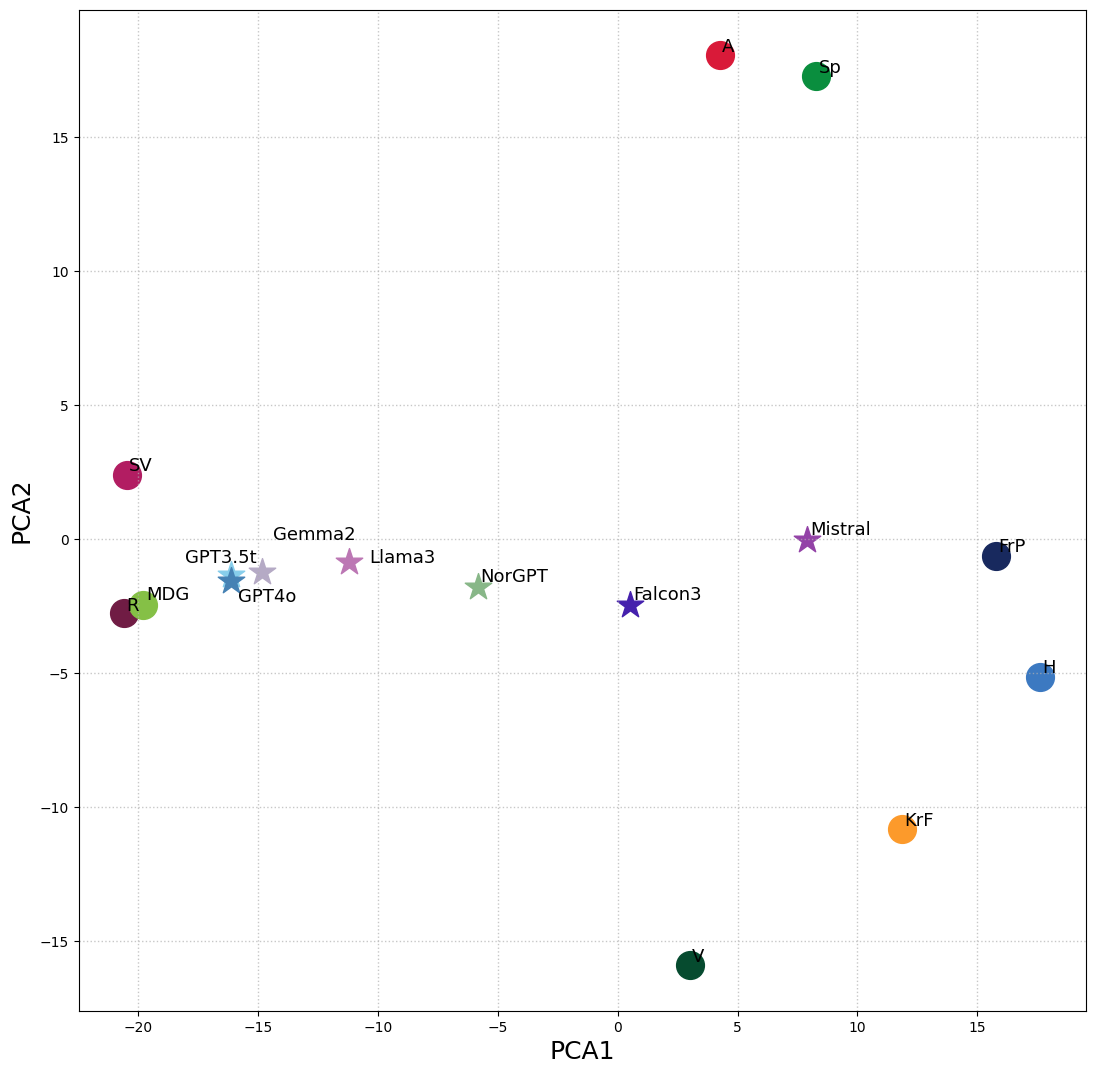

In [42]:
df_ideology.set_index('id', inplace=True, drop=False)

cat_signs = [[-1, 1] for _ in range(len(categories))] 
#cat_sign


cat_signs[4] = [-1, -1]
cat_signs[6] = [-1, -1]
if exp_var == 2:
    cat_signs[5] = [-1, -1]
    cat_signs[6] = [-1, 1]
    cat_signs[8] = [-1, -1]

fig_list = []
names_list = []
#for each category identify the subset and plot the ideology in the PCA space

for i, x in enumerate(categories):
    if x in df_cat2.columns:
        print("Category:", x)
        subset = df_ideology.loc[df_cat2[x] == 1].copy()
        print(len(subset))
        if len(subset) > 1:
            fig_list.append("Cat"+x.replace(" ", "_")+"_plot_\expvar")
            names_list.append(x)
            print(i)

            # Fit on parties  and p
            if not fit_pca_parties:
                utils.plot_landscape2(subset, "Cat "+x, model_names_short_list, exp, party_codes, colors_models, colors_parties, exp_var, signs=cat_signs[i], show=True)
            else:
                # Fit on parties
                #pca_parties_df, pca_model = utils.plot_landscape2(subset, "Cat "+x, [], exp, party_codes,[], colors_parties, exp_var, signs=cat_signs[i])
                pca_parties_df_cat, pca_model_cat = utils.do_PCA(subset, [], party_codes)
                # transform models
                pca_models_df_cat, _ = utils.do_PCA(subset, model_names_short_list, [], pca_model=pca_model_cat)
                pca_df_cat = pd.concat([pca_parties_df_cat, pca_models_df_cat], ignore_index=False)
                utils.make_landscape_plot(pca_df_cat,
                      "Cat "+x,
                      model_names_short_list,
                      "NO",
                      party_codes,
                      colors_models,
                      colors_parties,
                      exp_var, signs=cat_signs[i])
                
    else:
        print("not exist", x)


## Persona

In [43]:
dfs_persona = {}

directions = ['left', 'right', 'center']

remove_models = [] #['nor-mistral-instruct']

# Until Ready
for remove_model in remove_models:
    if remove_model in model_names:
        model_names.remove(remove_model)
        model_names_short_list.remove(model_names_short[remove_model])

# Only ones who have the persona, experiments
for model_name in model_names:
    model_suf = model_sufs[model_name]
    #if "gpt" in model_name:
    #    if "3.5" in model_name:
    #        model_suf = model_suf.replace("prompt=5", "prompt=4")

    persona_file = f"{results_folder}/{model_name}_results_persona{model_suf}{debug_suffix}.csv"
    dfs_persona[model_name] = pd.read_csv(persona_file, index_col=0)
    dfs_persona[model_name].set_index('id', inplace=True, drop=False) 
    
    for direction in directions:
        col = f'{model_name}_{direction}_vote'
        dfs_persona[model_name][col] = dfs_persona[model_name][col].str.lower().str.strip()
        dfs_persona[model_name][col] = dfs_persona[model_name][col].map(mappingNO)
        df_ideology[col] = dfs_persona[model_name][col].copy()

    df_ideology.rename(columns={f'{model_name}': f'{model_names_short[model_name]}',
                                f'{model_name}_{directions[0]}_vote': f'{model_names_short[model_name]}-L',
                                f'{model_name}_{directions[2]}_vote': f'{model_names_short[model_name]}-C',
                                f'{model_name}_{directions[1]}_vote': f'{model_names_short[model_name]}-R'},
                                inplace=True)


## PCA

0
['GPT3.5t', 'GPT3.5t-L', 'GPT3.5t-C', 'GPT3.5t-R']
10584
                PCA1       PCA2
GPT3.5t    66.728046 -32.040522
GPT3.5t-L  76.638150 -34.460884
GPT3.5t-C  70.245263 -32.573102
GPT3.5t-R  29.133941 -15.339520
['#701C44', '#B21D62', '#85C046', '#D91A39', '#0A8E3E', '#064B2F', '#FC9A2B', '#3C79C1', '#18295E']
['#87CEEB', '#4682B4', '#BC77B4', '#9342A7', '#B5AAC5', '#4520AD', '#88B788', '#407240']
Index(['PCA1', 'PCA2'], dtype='object')


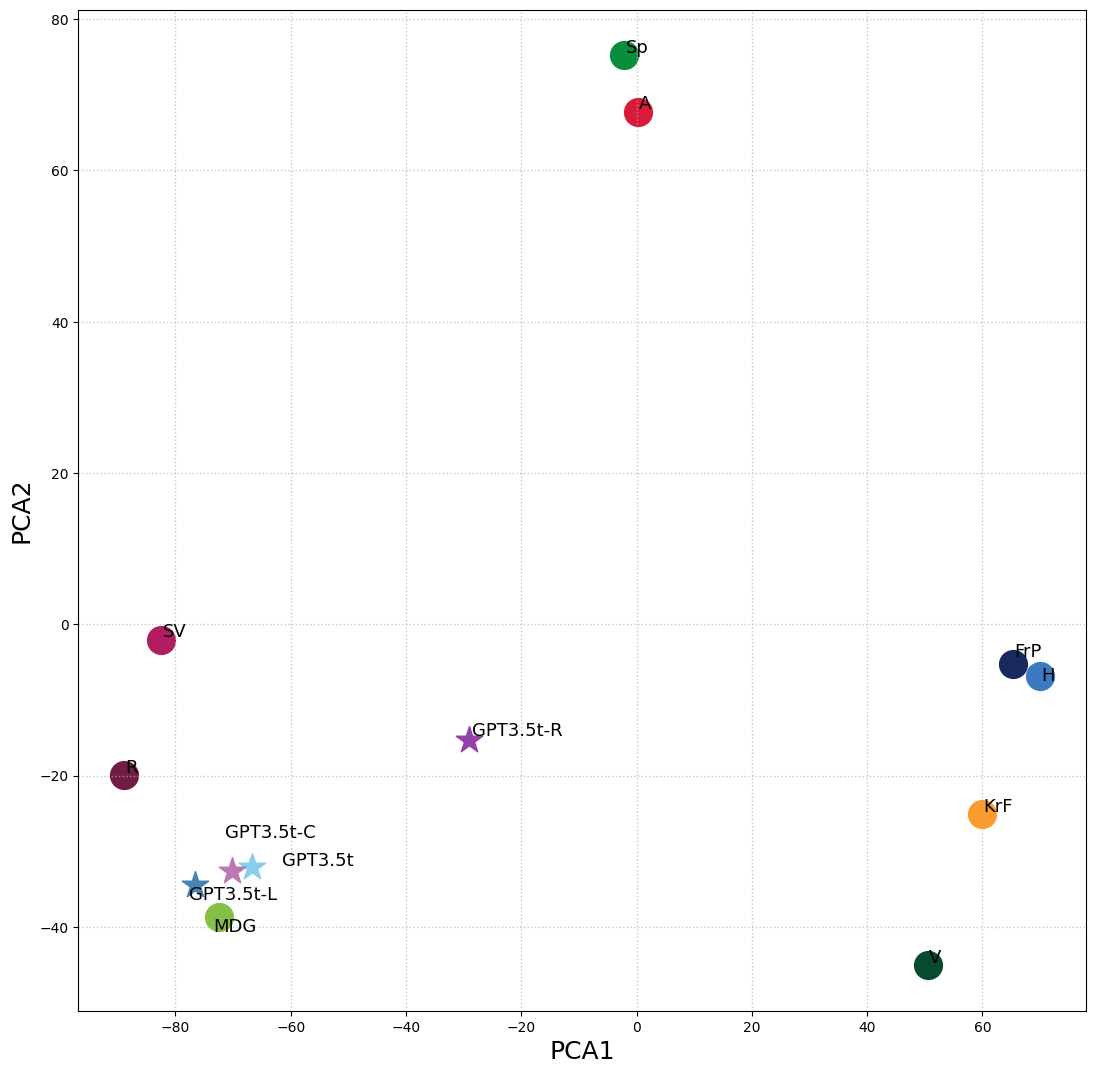

1
['GPT4o', 'GPT4o-L', 'GPT4o-C', 'GPT4o-R']
10584
              PCA1       PCA2
GPT4o    69.570594 -34.154945
GPT4o-L  77.404121 -35.191847
GPT4o-C  69.556405 -33.380923
GPT4o-R -20.776716   2.800231
['#701C44', '#B21D62', '#85C046', '#D91A39', '#0A8E3E', '#064B2F', '#FC9A2B', '#3C79C1', '#18295E']
['#87CEEB', '#4682B4', '#BC77B4', '#9342A7', '#B5AAC5', '#4520AD', '#88B788', '#407240']
Index(['PCA1', 'PCA2'], dtype='object')


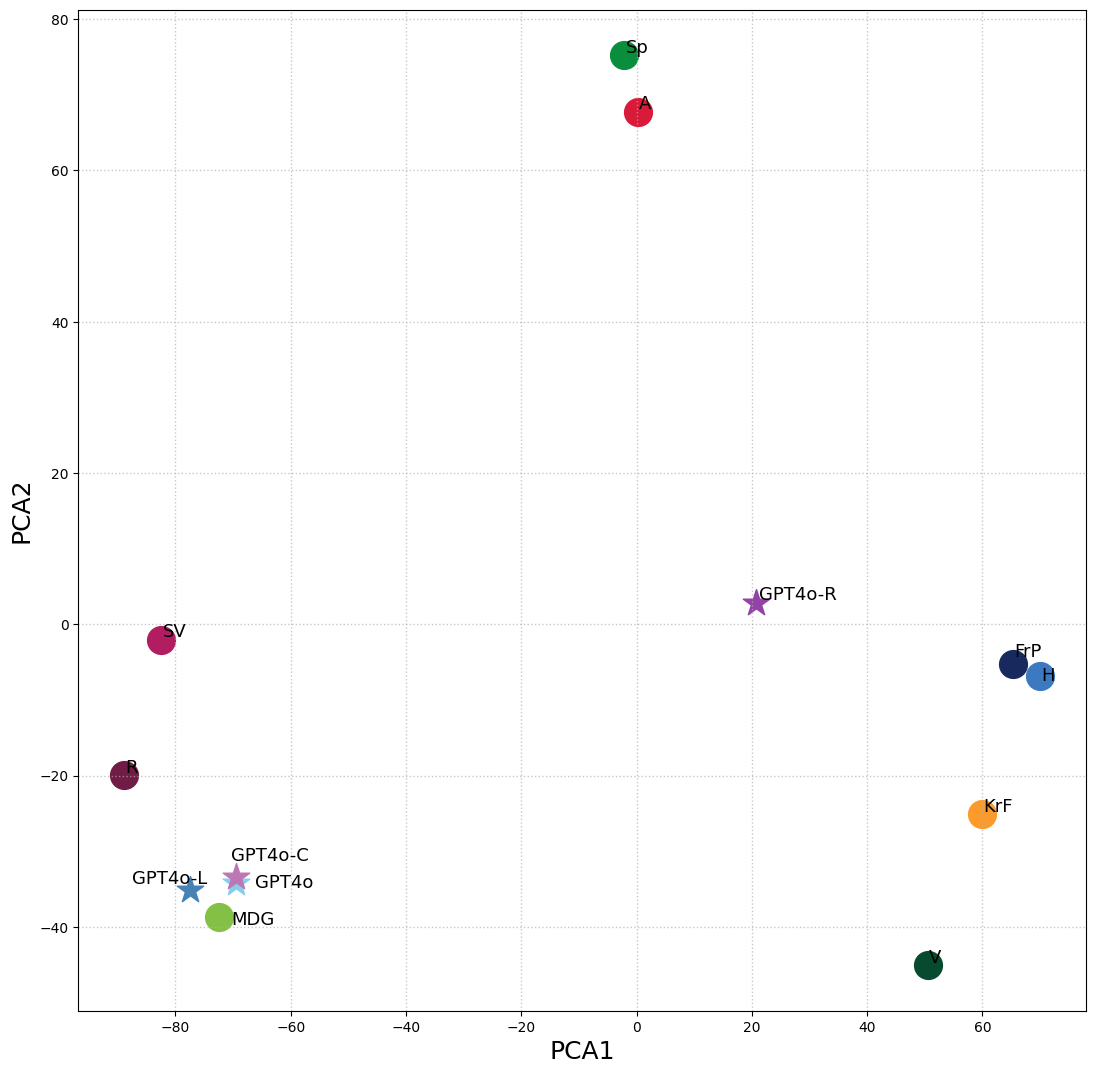

2
['Llama3', 'Llama3-L', 'Llama3-C', 'Llama3-R']
10584
               PCA1       PCA2
Llama3    45.910209 -23.295944
Llama3-L  56.746836 -28.089821
Llama3-C  54.190069 -27.052132
Llama3-R -39.810524  13.271962
['#701C44', '#B21D62', '#85C046', '#D91A39', '#0A8E3E', '#064B2F', '#FC9A2B', '#3C79C1', '#18295E']
['#87CEEB', '#4682B4', '#BC77B4', '#9342A7', '#B5AAC5', '#4520AD', '#88B788', '#407240']
Index(['PCA1', 'PCA2'], dtype='object')


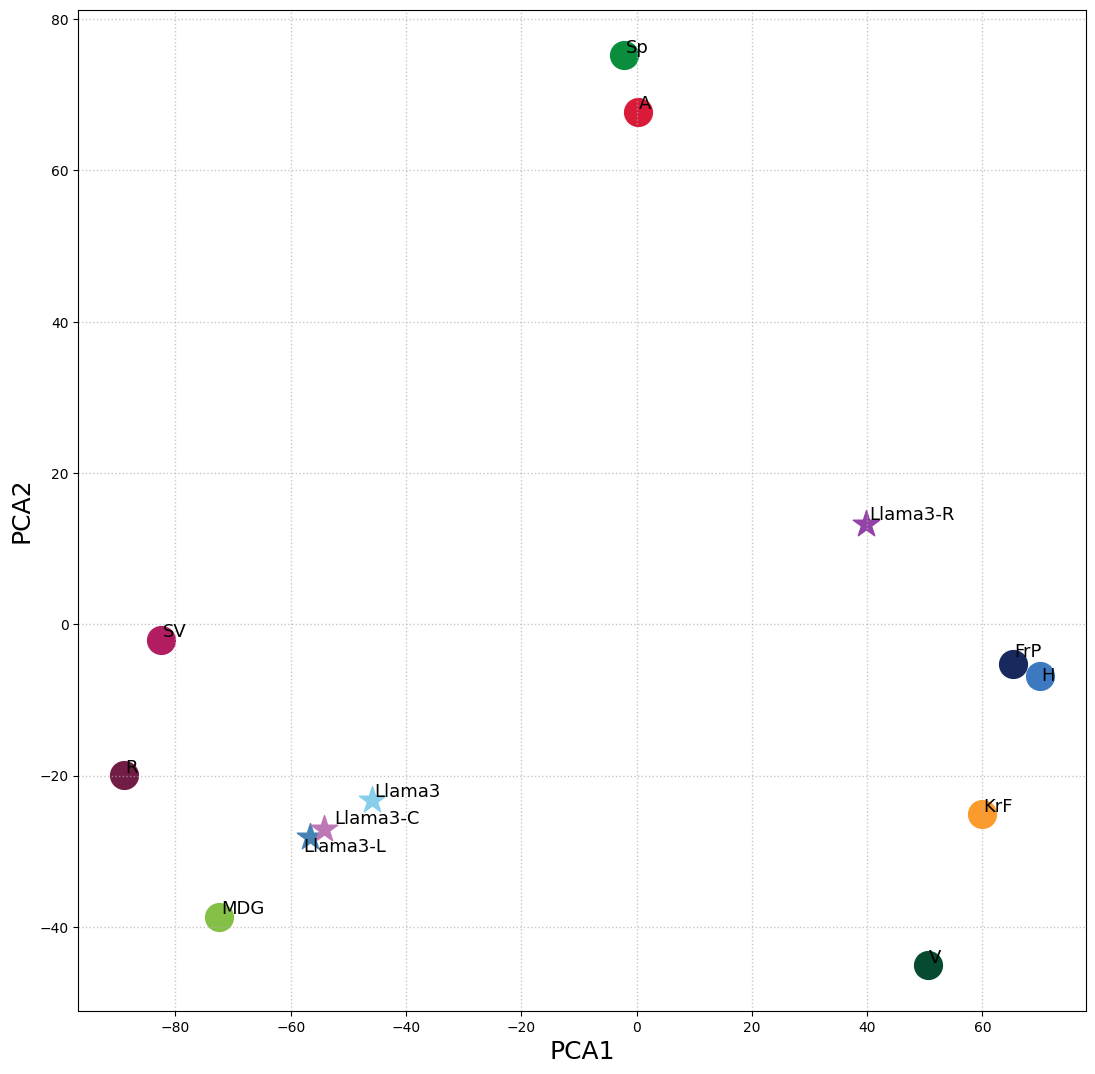

3
['Mistral', 'Mistral-L', 'Mistral-C', 'Mistral-R']
10584
                PCA1       PCA2
Mistral   -23.831753   4.561366
Mistral-L  31.076627 -19.147327
Mistral-C  27.519738 -17.770564
Mistral-R  23.554990 -15.937685
['#701C44', '#B21D62', '#85C046', '#D91A39', '#0A8E3E', '#064B2F', '#FC9A2B', '#3C79C1', '#18295E']
['#87CEEB', '#4682B4', '#BC77B4', '#9342A7', '#B5AAC5', '#4520AD', '#88B788', '#407240']
Index(['PCA1', 'PCA2'], dtype='object')


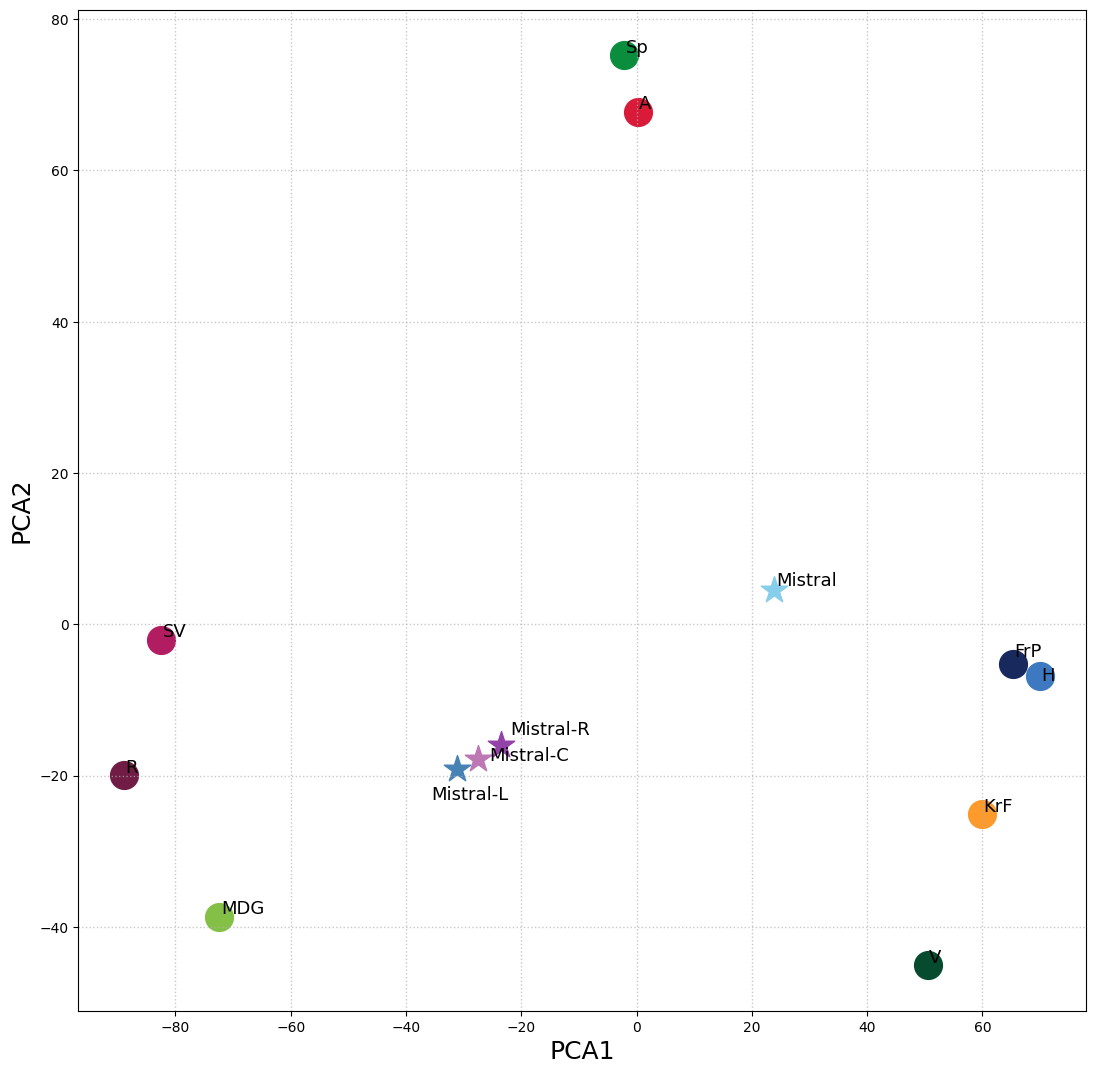

4
['Gemma2', 'Gemma2-L', 'Gemma2-C', 'Gemma2-R']
10584
               PCA1       PCA2
Gemma2    64.335971 -32.626426
Gemma2-L  74.426447 -34.140008
Gemma2-C  63.953952 -32.795133
Gemma2-R  13.057973  -7.462555
['#701C44', '#B21D62', '#85C046', '#D91A39', '#0A8E3E', '#064B2F', '#FC9A2B', '#3C79C1', '#18295E']
['#87CEEB', '#4682B4', '#BC77B4', '#9342A7', '#B5AAC5', '#4520AD', '#88B788', '#407240']
Index(['PCA1', 'PCA2'], dtype='object')


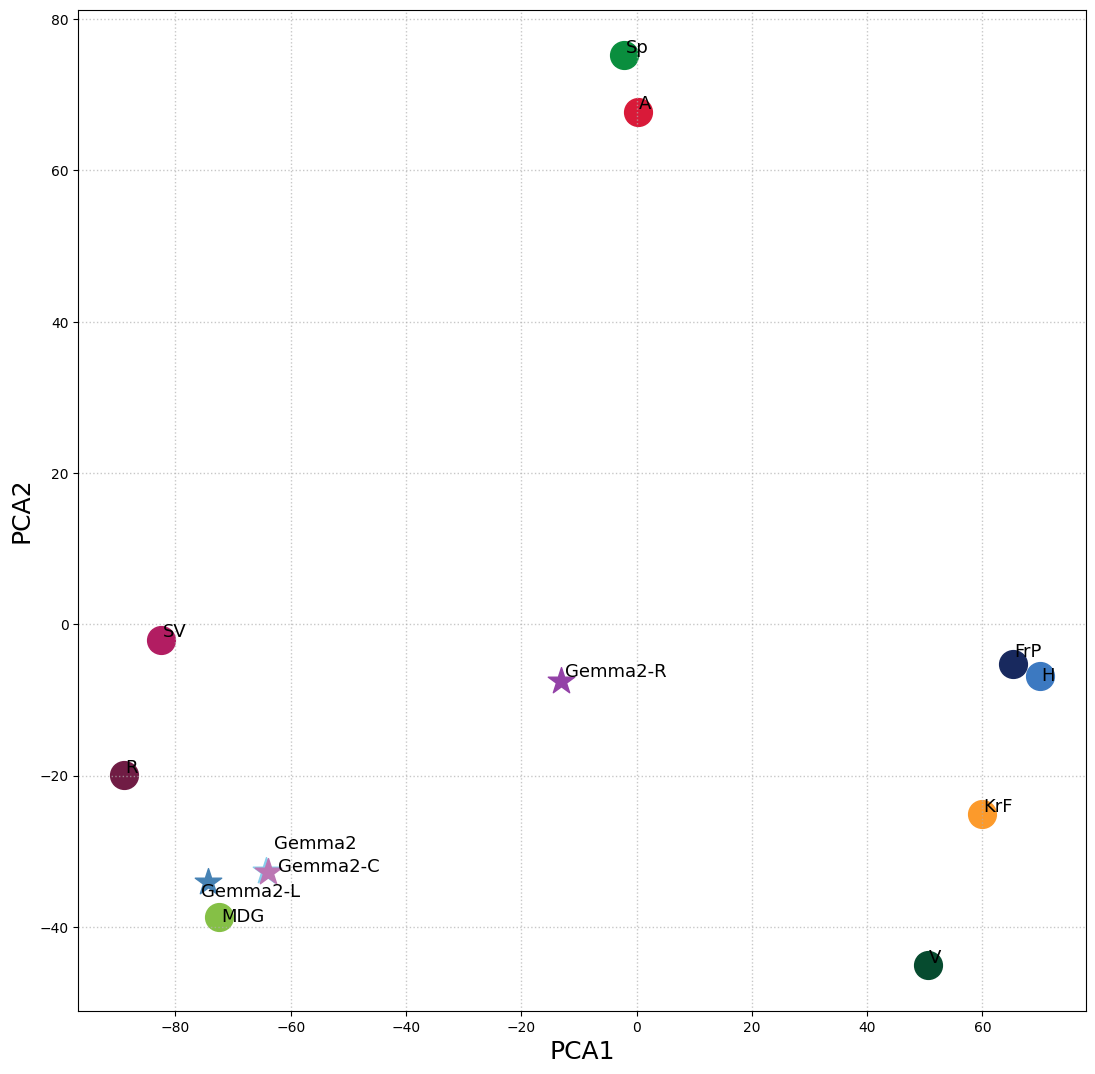

5
['Falcon3', 'Falcon3-L', 'Falcon3-C', 'Falcon3-R']
10584
                PCA1       PCA2
Falcon3     3.086758  -5.647772
Falcon3-L  72.467382 -34.372402
Falcon3-C  66.341423 -32.237589
Falcon3-R  23.138688  -9.993865
['#701C44', '#B21D62', '#85C046', '#D91A39', '#0A8E3E', '#064B2F', '#FC9A2B', '#3C79C1', '#18295E']
['#87CEEB', '#4682B4', '#BC77B4', '#9342A7', '#B5AAC5', '#4520AD', '#88B788', '#407240']
Index(['PCA1', 'PCA2'], dtype='object')


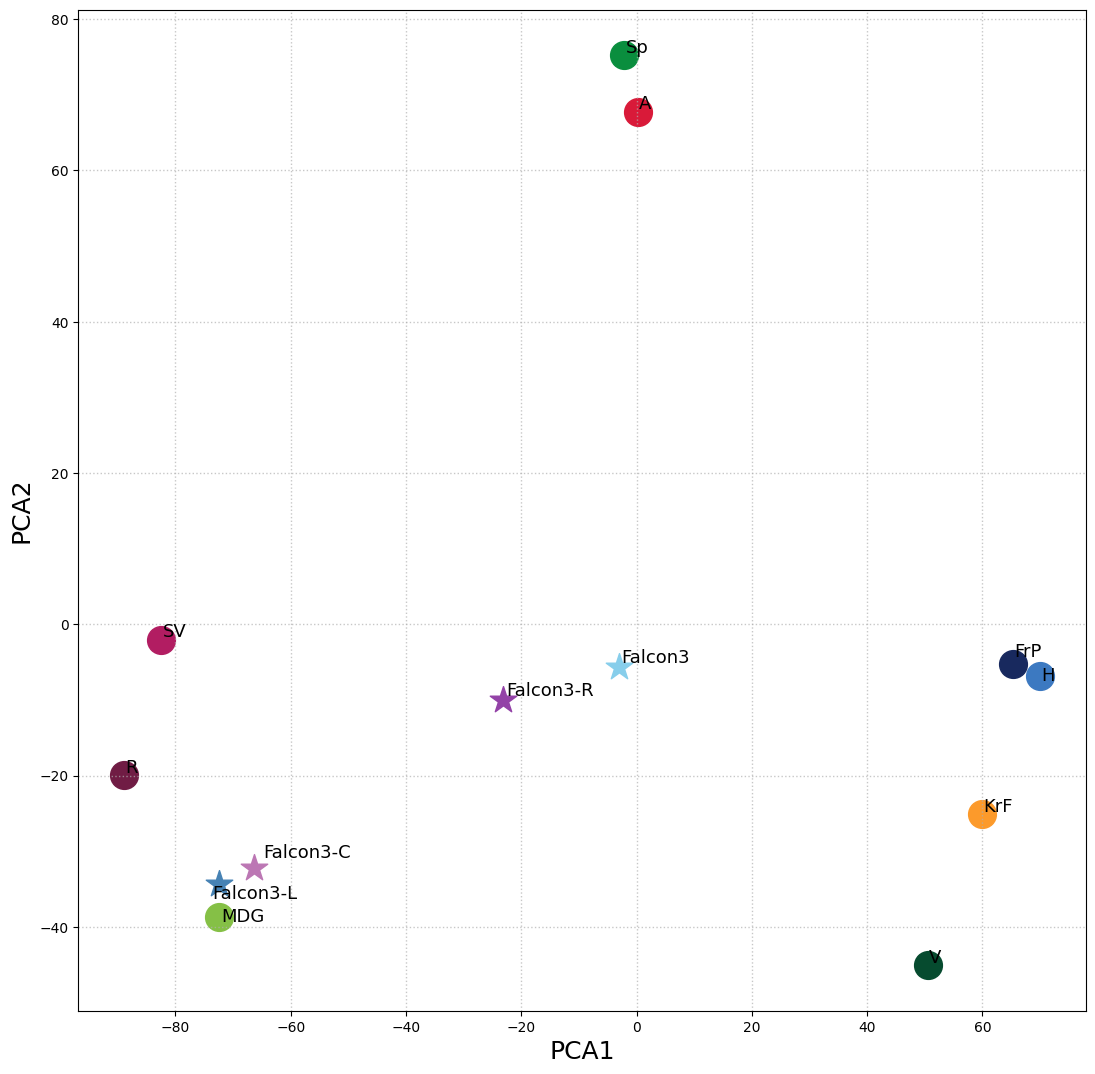

6
['NorGPT', 'NorGPT-L', 'NorGPT-C', 'NorGPT-R']
10584
               PCA1       PCA2
NorGPT    26.426649 -15.350118
NorGPT-L  74.663871 -34.759742
NorGPT-C  71.440963 -33.565913
NorGPT-R   7.496355  -5.117317
['#701C44', '#B21D62', '#85C046', '#D91A39', '#0A8E3E', '#064B2F', '#FC9A2B', '#3C79C1', '#18295E']
['#87CEEB', '#4682B4', '#BC77B4', '#9342A7', '#B5AAC5', '#4520AD', '#88B788', '#407240']
Index(['PCA1', 'PCA2'], dtype='object')


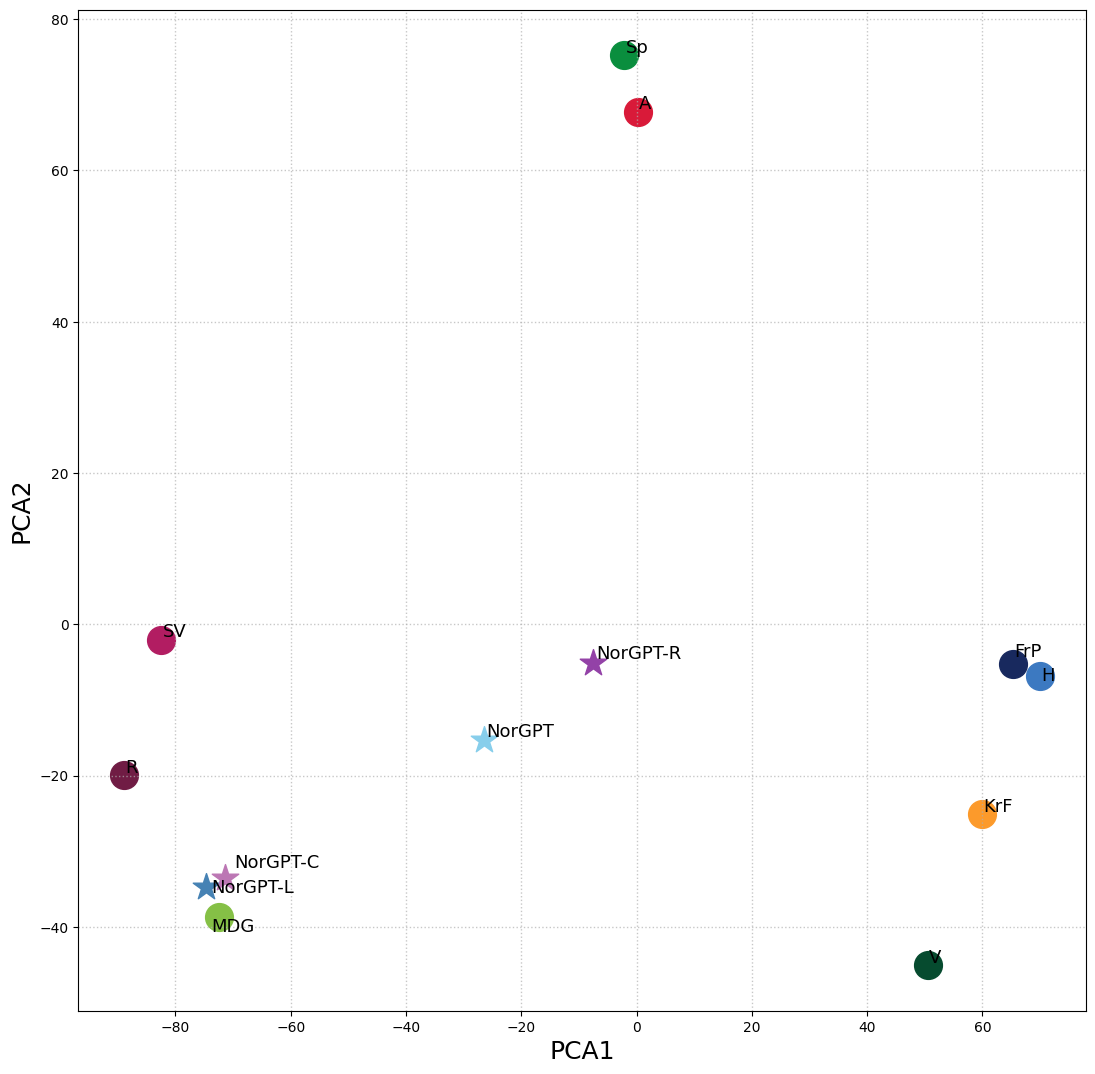

In [44]:
model_signs = [[-1, 1] for _ in range(len(model_names))] 


for i, model_name in enumerate(model_names):
    print(i)
    models = [f'{model_names_short[model_name]}',
              f'{model_names_short[model_name]}-L',
                f'{model_names_short[model_name]}-C',
                f'{model_names_short[model_name]}-R'
            ]
    print(models)
    
    pca_models_df, _ = utils.do_PCA(df_ideology, models, [], pca_model=pca_model)
    pca_df = pd.concat([pca_parties_df, pca_models_df], ignore_index=False)
    
    utils.make_landscape_plot(pca_df,
                               f'Persona {model_names_short[model_name]}',
                               models,
                              exp,
                              party_codes, colors_models, colors_parties,
                              exp_var, signs=model_signs[i])